# Palm 1 - Main : Data Transformation, EDA, Feature Engineering

## Executive Summary

### Problem Statement
Palm is a palm oil producing company in Southeast Asia relies heavily on natural elements like rain, soil type, terrain, etc., for a rich harvesting yield of the palm fruit and in return palm oil.  

Palm company needs the ability to accurately predict its palm fruit crop yield in the monthly and yearly horizon to enable forward contract for its product, i.e. Palm Oil. Today, it primarily relies on the experience and expertise of appointed agronomists to make such predictions. 

In addition to the experience and expertise of appointed agronomists, Palm Oil company will like to introduce data driven prediction methods for predicting its palm fruit yield and in return, its oil production. 

### Approach
- Raw data on daily rain & crop harvesting levels as well as static data on blocks is provided in excel 
- Advansed pandas data tranformation techniques are used to fused daily Rain and crop data  with blocks listed in static blocks dataset
- EDA was performed using daily and monthly agreed data at block level 
- Modeling is performed use two datasets, one with monthly data at estate level and other with monthly data at block level 
- Linear regression and Decision Tree - Random Forest algorithms from sklearn library are utilized
- Feature engineering includes shifting of rain data by multiple time periods like 6, 12, 24,26 months. 
- LassoCV algorithm was used to regularize linear regression model
- Max_depth is used as tuning parameter for Random Forest 
- R2 and RMSE metric are used to evaluate the models

### Notebooks 
Total of three notebooks are developed for this project:
- '../code/palm1_Main.ipynb' >>> First notebook used for data loading, cleaning & transformation as well as EDA
- '../code/palm2_modeling.ipynb' >>> notebook used for data modeling using Linear Regression 
- '../code/palm3_modeling.ipynb' >>> notebook used for data modeling using Random Forest 

### Datasets
-  '../data/block_syp_class.xlsx' >>> static blocks data received from the palm company
-  '../data/rain_and_crop.xlsx'   >>> daily rain and crop data received from the company
-  '../data/blocks.csv'   >>> blocks static data saved after transformation 
-  '../data/final_fused.csv' >>> final fused daily rain and crop data
-  '../data/final_fused_monthly.csv' >>> final fused monthly rain and crop data
**Note there are many interim files which are created & read during the data transformation process**

### Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
| crop | num | rain_crop| palm fruit harvest weight in tonnes|
| rain | num | rain_crop| rain fall in millimeters|
| blk | cat | blocks |name of the block |
| area_ha|num|blocks| Area in heactare for each block|
| no_of_palms|blocks| no of palms planted in each block|


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import math as math
import plotly.graph_objects as go

import time
import random
import seaborn as sns


import numpy as np
from os import path
from PIL import Image

from datetime import datetime
from dateutil import relativedelta
import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from io import StringIO

pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)



In [2]:
# My Custom color and font scheme - to be used across all graphs 
my_title_col = 'darkslategray'
my_label_col = 'darkslategray'
my_graph_col = 'darkcyan'
my_title_font = 24
my_label_font = 20
my_ticks_font = 18
sns.color_palette("YlOrBr");

#### Define Functions 

In [3]:
# Functions 

def age_in_months(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    months = difference.years * 12 + difference.months
    return months

def age_in_years(birth_date):
    difference = relativedelta.relativedelta(datetime.datetime.today(), birth_date)
    years = difference.years
    return years


##### Build Scores function

In [4]:
# Function to catupre evalting metrics from different models
scores_df = pd.DataFrame
scores_df = pd.DataFrame(columns=['Model Type','Dataset','Metric','Score'],index=None)

def scores(scores_df,model,dataset,metric,score):
    scores_df = scores_df.append({'Model Type':model,
                'Dataset': dataset,
                'Metric': metric,
                'Score':score},
                ignore_index=True)
    return scores_df

## Data Loading & Preprocessing 

In [5]:
# Block data with age and syp class proportion
blocks = pd.read_excel('../data/block_syp_class.xlsx', 
                    sheet_name='Details',
                      header=None)

blocks.columns=['blk','div','estate','plant_mat','area_ha','no_of_palms','mth_of_plant','yr_of_plant',
           'syp1_ha','syp1_prop','syp2_ha','syp2_prop','syp3_ha','syp3_prop','syp4_ha',
           'syp4_prop','syp5_ha','syp5_prop']

blocks.reindex()

blocks.drop(['div','estate','yr_of_plant'],axis=1,inplace=True)

#Making all block names as uppercase 
blocks['blk'] = blocks['blk'].apply(lambda x: x.upper())

# convert month of planting to datetime object
blocks['mth_of_plant'] = blocks['mth_of_plant'].apply(lambda x: str(x))
blocks['mth_of_plant'] = pd.to_datetime(blocks['mth_of_plant'],yearfirst=True,format="%Y/%m/%d")

#New features to blocks dataset with age in months and density (no of palms per hectare)
blocks['age'] = blocks['mth_of_plant'].apply(lambda x: age_in_months(x))

blocks['density'] = blocks['no_of_palms'] / blocks['area_ha']
blocks['density'] = blocks['density'].apply(lambda x: int(x))

# saving the cleaned data to csv
blocks.to_csv("../data/blocks.csv",index=False)




In [6]:
# cr_1014 - Crop data 2010 to 2014

cr_1014 = pd.read_excel('../data/rain_and_crop.xlsx',
                        sheet_name = 'Internal Crop FY 10-14',
                        skiprows = 4,
                        index_col=None,
                        header=0)

cr_1014.drop(['Company Belongs To','Block Type','Estate Name','Division Name','Unnamed: 1695'],
             axis=1,inplace=True)

cr_1014.drop(index=207,axis=0,inplace=True) #delete last row with all nulls

#removing first three character in the blockname to make it consistant with block_syp dataset
cr_1014['Block Name'] = cr_1014['Block Name'].apply(lambda x: x.replace(x[0:3],''))
cr_1014['Block Name'] = cr_1014['Block Name'].apply(lambda x: x.upper())


#Making all block names as uppercase 


# save this version for modeling 
cr_1014.to_csv('../data/cr_1014_mod.csv',index=None) 

#transposing 
cr_1014.set_index('Block Name',inplace=True) # to use first columns's values as column names
cr_1014_t = cr_1014.T.copy()
cr_1014_t.reset_index(inplace=True)
cr_1014_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
cr_1014_t['date'] = cr_1014_t['date'].apply(lambda x: str(x))
cr_1014_t['date'] = pd.to_datetime(cr_1014_t['date'],yearfirst=True,format="%Y/%m/%d")

#cr_1014_t.set_index('date', inplace=True, drop=True)

#dropping rows before 1-Apr-2011
cr_1014_t.drop(cr_1014_t[cr_1014_t['date'] < '2011-04-01'].index,inplace=True)

# fill null values with zero
cr_1014_t.fillna(0,inplace=True)

# saving the cleaned data to csv
cr_1014_t.to_csv("../data/cr_1114.csv",index=False)



In [7]:
# cr_1520 - Crop data 2015 to 2020


cr_1520 = pd.read_excel('../data/rain_and_crop.xlsx',
                        sheet_name = 'Internal Crop FY 15-20',
                        skiprows = 4,
                        index_col=None,
                        header=0)

cr_1520.drop(['Company Belongs To','Block Type','Estate Name','Division Name'],
             axis=1,inplace=True)

cr_1520.drop(index=200,axis=0,inplace=True) #delete last row with all nulls

#removing first three character and making  in the blockname to make it consistant with block_syp dataset
cr_1520['Block Name'] = cr_1520['Block Name'].apply(lambda x: x.replace(x[0:3],''))
cr_1520['Block Name'] = cr_1520['Block Name'].apply(lambda x: x.upper())

# save this version for modeling 
cr_1520.to_csv('../data/cr_1520_mod.csv',index=None) 

#transposing 
cr_1520.set_index('Block Name',inplace=True) # to use first columns's values as column names
cr_1520_t = cr_1520.T.copy()
cr_1520_t.reset_index(inplace=True)
cr_1520_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
cr_1520_t['date'] = cr_1520_t['date'].apply(lambda x: str(x))
cr_1520_t['date'] = pd.to_datetime(cr_1520_t['date'],yearfirst=True,format="%Y/%m/%d")

# fill null values with zero
cr_1520_t.fillna(0,inplace=True)

#save crop_data after 31-Mar-2020 in new dataset and dropped rows after 31-Mar-2020
cr_1520_t.drop(cr_1520_t[cr_1520_t['date'] > '2020-03-31'].index,inplace=True)
cr_2020_t = cr_1520_t[cr_1520_t['date'] > '2020-03-31'].copy()

#save cleaned file to csv file 
cr_1520_t.to_csv("../data/cr_1519.csv",index=False)
cr_2020_t.to_csv("../data/cr_2020.csv",index=False)



In [8]:
#rain dataset from 2010 to 2014
rn_1014 = pd.read_excel('../data/rain_and_crop.xlsx',
                        sheet_name = 'Rainfall FY 10-14',
                        skiprows = 4,
                        index_col=None,
                        header=0)

rn_1014.drop(['Company Belongs To','Block Type','Estate Name','Division Name'],
             axis=1,inplace=True)

rn_1014.drop(index=208,axis=0,inplace=True) #delete last row with all nulls

#removing first three character in the blockname to make it consistant with block_syp dataset
rn_1014['Block Name'] = rn_1014['Block Name'].apply(lambda x: x.replace(x[0:3],''))
rn_1014['Block Name'] = rn_1014['Block Name'].apply(lambda x: x.upper())


# save this version for modeling 
rn_1014.to_csv('../data/rn_1014_mod.csv',index=None) 

#transposing 
rn_1014.set_index('Block Name',inplace=True) # to use first columns's values as column names
rn_1014_t = rn_1014.T.copy()
rn_1014_t.reset_index(inplace=True)
rn_1014_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
rn_1014_t['date'] = rn_1014_t['date'].apply(lambda x: str(x))
rn_1014_t['date'] = pd.to_datetime(rn_1014_t['date'],yearfirst=True,format="%Y/%m/%d")

#dropping rows before 1-Apr-2011
rn_1014_t.drop(rn_1014_t[rn_1014_t['date'] < '2011-04-01'].index,inplace=True)

#saving cleaned dataset to csv file 
rn_1014_t.to_csv("../data/rn_1114.csv",index=False)

In [9]:
#rain dataset from 2015 to 2019
rn_1519 = pd.read_excel('../data/rain_and_crop.xlsx',
                        sheet_name = 'Rainfall FY 15-19',
                        skiprows = 4,
                        index_col=None,
                        header=0)

rn_1519.drop(['Company Belongs To','Block Type','Estate Name','Division Name','Unnamed: 1811'],
             axis=1,inplace=True)

rn_1519.drop(index=208,axis=0,inplace=True) #delete last row with all nulls

#removing first three character in the blockname to make it consistant with block_syp dataset
rn_1519['Block Name'] = rn_1519['Block Name'].apply(lambda x: x.replace(x[0:3],''))
rn_1519['Block Name'] = rn_1519['Block Name'].apply(lambda x: x.upper())


# save this version for modeling 
rn_1519.to_csv('../data/rn_1519_mod.csv',index=None) 


#transposing 
rn_1519.set_index('Block Name',inplace=True) # to use first columns's values as column names
rn_1519_t = rn_1519.T.copy()
rn_1519_t.reset_index(inplace=True)
rn_1519_t.rename(columns={'index':'date'},inplace=True)

rn_1519_t.drop(index=1097,axis=0,inplace=True) #delete row with date value as 'Unnamed: 1102'

#covert date to pd.datetime and setting 
rn_1519_t['date'] = rn_1519_t['date'].apply(lambda x: str(x))
rn_1519_t['date'] = pd.to_datetime(rn_1519_t['date'],yearfirst=True,format="%Y/%m/%d")

#save cleaned dataset to csv file
rn_1519_t.to_csv("../data/rn_1519.csv",index =False)

In [10]:
#rain datasetfor 2020
rn_20 = pd.read_excel('../data/rain_and_crop.xlsx',
                        sheet_name = 'Rainfall FY20',
                        skiprows = 4,
                        index_col=None,
                        header=0)

rn_20.drop(['Company Belongs To','Block Type','Estate Name','Division Name'],
             axis=1,inplace=True)

rn_20.drop(index=198,axis=0,inplace=True) #delete last row with all nulls

#removing first three character in the blockname to make it consistant with block_syp dataset
rn_20['Block Name'] = rn_20['Block Name'].apply(lambda x: x.replace(x[0:3],''))
rn_20['Block Name'] = rn_20['Block Name'].apply(lambda x: x.upper())

                                                
# save this version for modeling 
rn_20.to_csv('../data/rn_2020_mod.csv',index=None) 

#transposing 
rn_20.set_index('Block Name',inplace=True) # to use first columns's values as column names
rn_20_t = rn_20.T.copy()
rn_20_t.reset_index(inplace=True)
rn_20_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
rn_20_t['date'] = rn_20_t['date'].apply(lambda x: str(x))
rn_20_t['date'] = pd.to_datetime(rn_20_t['date'],yearfirst=True,format="%Y/%m/%d")
                                                
# save cleaned dataset to csv
rn_20_t.to_csv("../data/rn_2020.csv",index=False)

## Data Transformation for EDA

### Load cleaned and preprocessed datasets
- Blocks => master data on blocks with area, age and syp class proportions
- rn_1114 => blockwise daily rain data from 1st Apr 2011 to 31st Mar 2015
- rn_1519 => blockwise daily rain data from 1st Apr 2015 to 31st Mar 2020
- rn_2020 => blockwise daily rain data from 1st Apr 2020 onwards
- cr_1114 => blockwise daily crop harvesting data from 1st Apr 2011 to 31st Apr 2015
- cr_1519 => blockwise daily crop harvesting data from 1st Apr 2015 to 31st Mar 2015
- cr_2020 => blockwise daily crop harvesting data from 1st Apr 2020 onwards

In [11]:
# load data
blocks = pd.read_csv("../data/blocks.csv")
cr1114 = pd.read_csv("../data/cr_1114.csv")
cr1519 = pd.read_csv("../data/cr_1519.csv")
cr2020 = pd.read_csv("../data/cr_2020.csv")
rn1114 = pd.read_csv("../data/rn_1114.csv")
rn1519 = pd.read_csv("../data/rn_1519.csv")
rn2020 = pd.read_csv("../data/rn_2020.csv")


# convert month of planting to datetime object
blocks['mth_of_plant'] = blocks['mth_of_plant'].apply(lambda x: str(x))
blocks['mth_of_plant'] = pd.to_datetime(blocks['mth_of_plant'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
cr1114['date'] = cr1114['date'].apply(lambda x: str(x))
cr1114['date'] = pd.to_datetime(cr1114['date'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
cr1519['date'] = cr1519['date'].apply(lambda x: str(x))
cr1519['date'] = pd.to_datetime(cr1519['date'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
cr2020['date'] = cr2020['date'].apply(lambda x: str(x))
cr2020['date'] = pd.to_datetime(cr2020['date'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
rn1114['date'] = rn1114['date'].apply(lambda x: str(x))
rn1114['date'] = pd.to_datetime(rn1114['date'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
rn1519['date'] = rn1519['date'].apply(lambda x: str(x))
rn1519['date'] = pd.to_datetime(rn1519['date'],yearfirst=True,format="%Y/%m/%d")

#covert date to pd.datetime and setting 
rn2020['date'] = rn2020['date'].apply(lambda x: str(x))
rn2020['date'] = pd.to_datetime(rn2020['date'],yearfirst=True,format="%Y/%m/%d")



### Final Data Fusion
**'final_fused.csv' dataset is created which includes month level crop and rain data at Estate Level.**

- Create list of columns for each dataset required for melt functions
- Melt each dataset using the new created column lists 
- concatinate all rain datasets 
- concatinate all crop datasets
- Merge rain and crop data into rain_crop on date and blk with 'outer' join
- Merge rain_crop data with blocks dateset into df on blk and 'left' join.
- Drop rows with no block attributes like age as those records belong to blocks which don't exist now in master dataset

#### Melting of rain and crop datasets

In [12]:
# create list of columns for each datasets to use for melt function
rn1114_cols = []
rn1519_cols = []
rn2020_cols = []

cr1114_cols = []
cr1519_cols = []
cr2020_cols = []

for blk,vals in rn1114.iteritems():
    if blk != 'date':
        rn1114_cols.append(blk)

for blk,vals in rn1519.iteritems():
    if blk != 'date':
        rn1519_cols.append(blk)   
        
for blk,vals in rn2020.iteritems():
    if blk != 'date':
        rn2020_cols.append(blk)   
        
for blk,vals in cr1114.iteritems():
    if blk != 'date':
        cr1114_cols.append(blk)

for blk,vals in cr1519.iteritems():
    if blk != 'date':
        cr1519_cols.append(blk)   
        
for blk,vals in cr2020.iteritems():
    if blk != 'date':
        cr2020_cols.append(blk)   
        
print(len(rn1114_cols),len(rn1519_cols),len(cr1114_cols),len(cr1519_cols))
print(rn1114.shape,rn1519.shape,cr1114.shape,cr1519.shape)        

208 208 207 200
(1461, 209) (1805, 209) (1342, 208) (1664, 201)


In [13]:
# Melt function for each of the rain and crop datasets

rn1114_melt = pd.melt(rn1114, id_vars=['date'], 
                           value_vars=rn1114_cols, 
                           var_name= 'blk', 
                           value_name='rain')

rn1519_melt = pd.melt(rn1519, id_vars=['date'], 
                           value_vars=rn1519_cols, 
                           var_name= 'blk', 
                           value_name='rain')

rn2020_melt = pd.melt(rn2020, id_vars=['date'], 
                           value_vars=rn2020_cols, 
                           var_name= 'blk', 
                           value_name='rain')

cr1114_melt = pd.melt(cr1114, id_vars=['date'], 
                           value_vars=cr1114_cols, 
                           var_name= 'blk', 
                           value_name='crop')

cr1519_melt = pd.melt(cr1519, id_vars=['date'], 
                           value_vars=cr1519_cols, 
                           var_name= 'blk', 
                           value_name='crop')

cr2020_melt = pd.melt(cr2020, id_vars=['date'], 
                           value_vars=cr2020_cols, 
                           var_name= 'blk', 
                           value_name='crop')

print(rn1114_melt.shape,rn1519_melt.shape,cr1114_melt.shape,cr1519_melt.shape)

(303888, 3) (375440, 3) (277794, 3) (332800, 3)


#### Concatinating all rain dataset into one
#### Concatinating all crop dataset into one

In [14]:
# concatinating all rain data sets to rain & all crop datasets to crop
rain = pd.concat([rn1114_melt,rn1519_melt,rn2020_melt],ignore_index=True)
crop = pd.concat([cr1114_melt,cr1519_melt,cr2020_melt],ignore_index=True)

print(rain.shape,crop.shape)

(708830, 3) (610594, 3)


In [15]:
rain['blk'].unique()

array(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09',
       'A10', 'A100', 'A101', 'A102', 'A11', 'A12', 'A13', 'A14', 'B01',
       'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10',
       'B100', 'B101', 'B102', 'B103', 'B104', 'B105', 'B106', 'B11',
       'B12', 'B13', 'B14', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06',
       'C07', 'C08', 'C09', 'C10', 'C100', 'C101', 'C102', 'C103', 'C104',
       'C105', 'C106', 'C11', 'C12', 'C13', 'C14', 'D02', 'D03', 'D04',
       'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D102', 'D103', 'D104',
       'D105', 'D106', 'D11', 'E01', 'E02', 'E03', 'E04', 'E05', 'E05A',
       'E05B', 'E06A', 'E06B', 'E07A', 'E07B', 'E08A', 'E08B', 'E09A',
       'E09B', 'E10', 'E100', 'E102', 'E103', 'E104', 'E105', 'E106',
       'E10A', 'E10B', 'E11', 'E12', 'F04', 'F05', 'F05A', 'F05B', 'F06',
       'F06A', 'F06B', 'F07A', 'F07B', 'F08', 'F09', 'F10', 'F102',
       'F103', 'F105', 'F106', 'F11', 'F12', 'G04', 'G05', 'G06', 'G07'

In [16]:
rain.info()
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708830 entries, 0 to 708829
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    708830 non-null  datetime64[ns]
 1   blk     708830 non-null  object        
 2   rain    700062 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 16.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610594 entries, 0 to 610593
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    610594 non-null  datetime64[ns]
 1   blk     610594 non-null  object        
 2   crop    610594 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.0+ MB


#### merging of rain and crop datasets

In [17]:
# Merge rain and crop datasets with outer join. 
# This should provide datasets with rain and crop data for each day & block 

#Making all block names as uppercase 
rain['blk'] = rain['blk'].apply(lambda x: x.upper())
crop['blk'] = crop['blk'].apply(lambda x: x.upper())


# merging
rain_crop = pd.DataFrame
rain_crop = pd.merge(rain,crop,
                     how='outer', 
                     left_on=['date','blk'],
                     right_on=['date','blk'],
                    copy=False)
print(rain_crop.shape)

(712630, 4)


#### Merging of Blocks with Rain_Crop Datasets

In [18]:
# merging rain_crop with blocks dataset
df = pd.DataFrame
df = pd.merge(blocks,rain_crop,
                how='left', 
                on = 'blk', 
                copy=False)

print(df.shape)

(662596, 20)


In [19]:
df.shape

(662596, 20)

In [20]:
# looking for rows with rain or crop information, however block does not exist in master blocks data. 
df.isnull().sum()
# there are 62282 such rows.

blk                 0
plant_mat           0
area_ha             0
no_of_palms         0
mth_of_plant        0
syp1_ha             0
syp1_prop           0
syp2_ha             0
syp2_prop           0
syp3_ha             0
syp3_prop           0
syp4_ha             0
syp4_prop           0
syp5_ha             0
syp5_prop           0
age                 0
density             0
date                2
rain             9004
crop            85444
dtype: int64

In [21]:
# droping rows with rain and crop data by block is not listed in blocks dataset. 
df.shape
df.drop(df[df['age'].isnull()].index,inplace=True)
df.shape

(662596, 20)

In [22]:
# number of rain cells with null values
df['rain'].isnull().sum()

9004

In [23]:
# number of crop cells with null values
df['crop'].isnull().sum()

85444

#### Imputation of rain and crop data

In [24]:
### Impute rain (8822 cells) & Crop (55718 cells)
# Since the number rows with NaN rain are a fraction of totals rows, taking an approach to 
df['rain'].fillna(0, inplace = True)
df['crop'].fillna(0, inplace = True)

### Create CSV file of final fused dataset

In [25]:
df.to_csv('../data/final_fused.csv',index=False)
rain_crop.to_csv('../data/final_rain_crop.csv',index=False)

### Creating copies of fused dataframe for different purposes

In [26]:
# indexing the EDA purpose - data between 1-Apr2011 and 31-Mar-2020
dfi = df[df['date'] < '2020-04-01'].copy()
dfi = dfi.set_index('date', drop=True)
print(df.shape,' ',dfi.shape)

(662596, 20)   (633986, 19)


In [27]:
# monthly rain and crop data
df_m = dfi[['rain','crop']].resample('M').sum()
df_m['date'] = df_m.index.date
df_m['rain'] = df_m['rain'].apply(lambda x: (x/195)) # dividing the rain by number of blocks
df_m['date'] = df_m['date'].apply(lambda x: str(x))
df_m['date'] = pd.to_datetime(df_m['date'],yearfirst=True,format="%Y/%m") 
df_m['month'] = df_m['date'].apply(lambda x: x.strftime("%b-%Y"))# converting to name of the months and year
df_m.head()

,rain,crop,date,month
date,,,,
2011-04-30,243.377949,7994.20059,2011-04-30,Apr-2011
2011-05-31,93.778205,8614.03416,2011-05-31,May-2011
2011-06-30,67.302564,7714.13505,2011-06-30,Jun-2011
2011-07-31,119.758974,8511.76212,2011-07-31,Jul-2011
2011-08-31,5.344615,7345.95696,2011-08-31,Aug-2011


In [28]:
blocks.shape

(195, 17)

## Data Transformation for Modeling 

**'final_fused_monthly.csv' dataset is  created which includes month level crop and rain data for each block.**

To include the block in the monthly level data, following data transformation steps were executed:
- rain and crop data from various periods were concatenated.
- rain and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- crop and block(only 'block' feature) datasets are merged to select only those blocks present in blocks dataset
- new rain & crop datasets are transposed to have date as one column and each blocks as one column
- new rain & crop datasets are resampled to have monthly summed rain and crop data for each block
- rain and crop dataset are melted to have one column for all blocks and all 'dates'(months) are repeated for each block.
- rain and crop are merged to have one final dataset with date(month),block,rain,crop.

In [29]:
blocks = pd.read_csv("../data/blocks.csv")
cr1014_mod = pd.read_csv("../data/cr_1014_mod.csv")
cr1520_mod = pd.read_csv("../data/cr_1520_mod.csv")
rn1014_mod = pd.read_csv("../data/rn_1014_mod.csv")
rn1519_mod = pd.read_csv("../data/rn_1519_mod.csv")
rn2020_mod = pd.read_csv("../data/rn_2020_mod.csv")

# merging crop from 2010 to 2020
cr1020_mod = pd.DataFrame
cr1020_mod = pd.merge(cr1014_mod,cr1520_mod,
                how='outer', 
                on = 'Block Name', 
                copy=False)

# merging rain from 2010 to 2019
rn1019_mod = pd.DataFrame
rn1019_mod = pd.merge(rn1014_mod,rn1519_mod,
                how='outer', 
                on = 'Block Name', 
                copy=False)

# rain from 2010 to 2020
rn1020_mod = pd.DataFrame
rn1020_mod = pd.merge(rn1019_mod,rn2020_mod,
                how='outer', 
                on = 'Block Name', 
                copy=False)

# Rain & bl to match blocks with blocks dataset and lose any addtional blcoks from rain dataset

rn_bl_1020_mod = pd.DataFrame
rn_bl_1020_mod = pd.merge(blocks['blk'],rn1020_mod,
                how='left', 
                left_on = 'blk', 
                right_on = 'Block Name', 
                copy=False)
#drop addtional column 'Block Name'
rn_bl_1020_mod.drop(['Block Name'],axis=1,inplace=True)

# crop & bl to match blocks with blocks dataset and lose any addtional blcoks from crop dataset
cr_bl_1020_mod = pd.DataFrame
cr_bl_1020_mod = pd.merge(blocks['blk'],cr1020_mod,
                how='left', 
                left_on = 'blk', 
                right_on = 'Block Name', 
                copy=False)

#drop addtional column 'Block Name'
cr_bl_1020_mod.drop(['Block Name'],axis=1,inplace=True)

#################################################################################################
#  ******* Transposing and filtering and saving final version of rn_bl data ***********************
rn_bl_1020_mod.set_index('blk',inplace=True) # to use first columns's values as column names
rn_bl_1020_t = rn_bl_1020_mod.T.copy()
rn_bl_1020_t.reset_index(inplace=True)
rn_bl_1020_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
rn_bl_1020_t['date'] = rn_bl_1020_t['date'].apply(lambda x: str(x))

#drop row with 'Unnamed 1102' value.
rn_bl_1020_t.drop(rn_bl_1020_t[rn_bl_1020_t['date'] == 'Unnamed: 1102'].index,inplace=True)

rn_bl_1020_t['date'] = pd.to_datetime(rn_bl_1020_t['date'],yearfirst=True,format="%Y/%m/%d")

# Keep observations between 01-Apr-2011 and 31-May-2020
rn_bl_1020_t.drop(rn_bl_1020_t[rn_bl_1020_t['date'] < '2011-04-01'].index,inplace=True)
rn_bl_1020_t.drop(rn_bl_1020_t[rn_bl_1020_t['date'] > '2020-05-31'].index,inplace=True)


# resample for monthly totals 
rn_bl_1020_i = rn_bl_1020_t.copy()
rn_bl_1020_i = rn_bl_1020_i.set_index('date', drop=True) # set date as index
rn_bl_1020_m = rn_bl_1020_i.resample('M').sum() # resampling for monthly totals

# Save cleaned dataset to csv
rn_csv = rn_bl_1020_m.reset_index()
rn_csv.to_csv("../data/rn_bl_1120.csv",index=False)

#################################################################################################
# Transposing and filtering and saving final version of cr_bl data   
cr_bl_1020_mod.set_index('blk',inplace=True) # to use first columns's values as column names
cr_bl_1020_t = cr_bl_1020_mod.T.copy()
cr_bl_1020_t.reset_index(inplace=True)
cr_bl_1020_t.rename(columns={'index':'date'},inplace=True)

#covert date to pd.datetime and setting 
cr_bl_1020_t['date'] = cr_bl_1020_t['date'].apply(lambda x: str(x))
cr_bl_1020_t['date'] = pd.to_datetime(cr_bl_1020_t['date'],yearfirst=True,format="%Y/%m/%d")

# Keep observations between 01-Apr-2011 and 31-May-2020
cr_bl_1020_t.drop(cr_bl_1020_t[cr_bl_1020_t['date'] < '2011-04-01'].index,inplace=True)
cr_bl_1020_t.drop(cr_bl_1020_t[cr_bl_1020_t['date'] > '2020-05-31'].index,inplace=True)

# resample for monthly totals 
cr_bl_1020_i = cr_bl_1020_t.copy()
cr_bl_1020_i = cr_bl_1020_i.set_index('date', drop=True) # set date as index
cr_bl_1020_m = cr_bl_1020_i.resample('M').sum() # resampling for monthly totals

# Save cleaed dataset to csv
cr_csv = cr_bl_1020_m.reset_index()
cr_csv.to_csv("../data/cr_bl_1120.csv",index=False)

################################################################################################
# load final monthly rain and crop datasets
rain_m_1120 = pd.read_csv("../data/rn_bl_1120.csv")
crop_m_1120 = pd.read_csv("../data/cr_bl_1120.csv")

################################################################################################
# Melt & join 

# create list of columns for each datasets to use for melt function
rn_m_cols = []
cr_m_cols = []

for blk,vals in rain_m_1120.iteritems():
    if blk != 'date':
        rn_m_cols.append(blk)
        
for blk,vals in crop_m_1120.iteritems():
    if blk != 'date':
        cr_m_cols.append(blk)
           
rn1120_melt = pd.melt(rain_m_1120, id_vars=['date'], 
                           value_vars=rn_m_cols, 
                           var_name= 'blk', 
                           value_name='rain')

cr1120_melt = pd.melt(crop_m_1120, id_vars=['date'], 
                           value_vars=cr_m_cols, 
                           var_name= 'blk', 
                           value_name='crop')

# Merge rain and crop datasets with outer join. 
# This should provide datasets with rain and crop data for each month & block 
rain_crop_m = pd.DataFrame
rain_crop_m = pd.merge(rn1120_melt,cr1120_melt,
                     how='outer', 
                     left_on=['date','blk'],
                     right_on=['date','blk'],
                    copy=False)

rain_crop_m.to_csv("../data/final_fused_monthly.csv",index=None)

print(rn1120_melt.shape, cr1120_melt.shape, rain_crop_m.shape)
print(rain_crop_m.isnull().sum())

(21450, 3) (21450, 3) (21450, 4)
date    0
blk     0
rain    0
crop    0
dtype: int64


In [97]:
blocks['no_of_palms'].sum()

559593

In [94]:
dfi.head()

,blk,plant_mat,area_ha,no_of_palms,mth_of_plant,syp1_ha,syp1_prop,syp2_ha,syp2_prop,syp3_ha,syp3_prop,syp4_ha,syp4_prop,syp5_ha,syp5_prop,age,density,rain,crop
date,,,,,,,,,,,,,,,,,,,
2011-04-01,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,24.0,0.0
2011-04-02,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,8.9,0.0
2011-04-03,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,0.0,0.0
2011-04-04,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,3.8,0.0
2011-04-05,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,7.0,0.0


## EDA & Feature Engineering

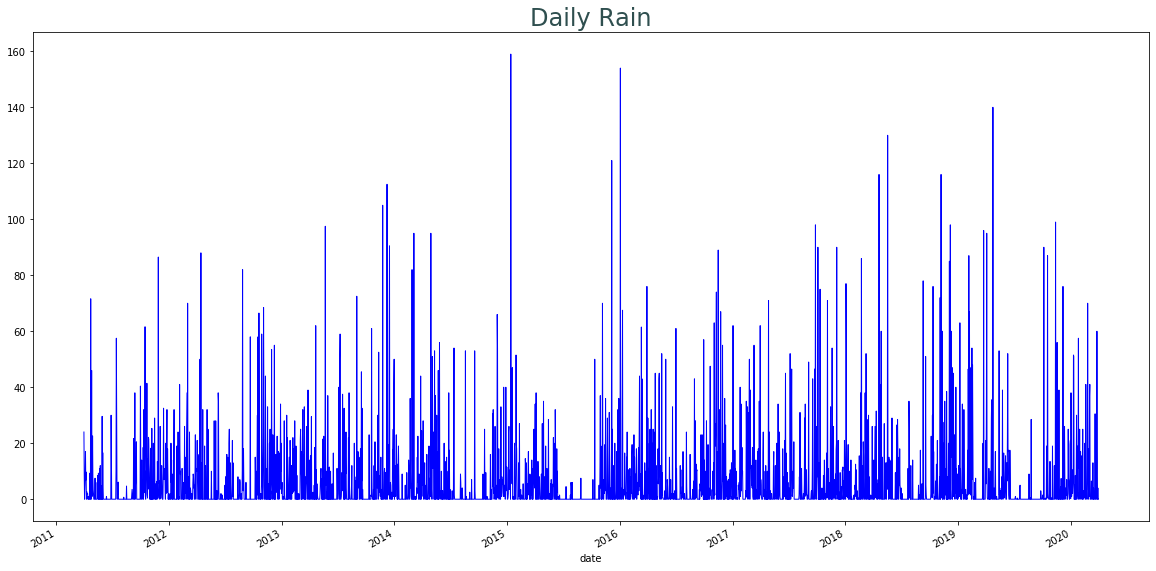

In [30]:
title = 'Daily Rain'
fig, ax = plt.subplots(figsize=(18,4));
dfi[dfi['blk'] == 'A01']['rain'].plot(figsize=(20,10),lw=1,color='blue');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

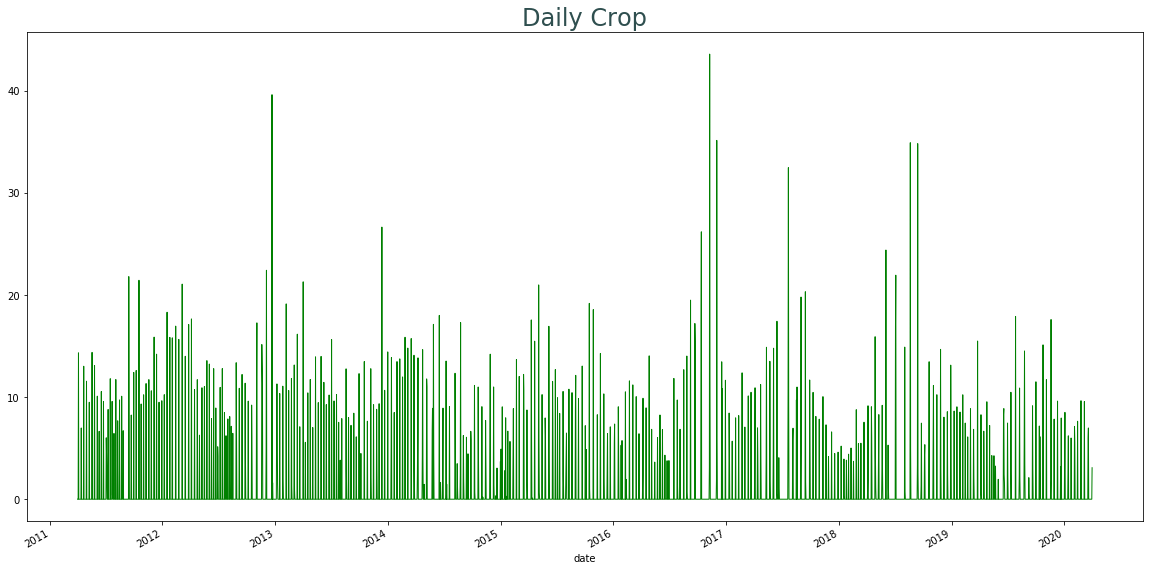

In [31]:
title = 'Daily Crop'
fig, ax = plt.subplots(figsize=(18,4));
dfi[dfi['blk'] == 'A01']['crop'].plot(figsize=(20,10),lw=1,color='green');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

In [32]:
blocks.head()

,blk,plant_mat,area_ha,no_of_palms,mth_of_plant,syp1_ha,syp1_prop,syp2_ha,syp2_prop,syp3_ha,syp3_prop,syp4_ha,syp4_prop,syp5_ha,syp5_prop,age,density
0,A07,DAMI,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139
1,A08,DAMI,21.7,2911,1999-03-01,10.4,0.479263,7.7,0.354839,0.0,0.0,3.6,0.165899,0.0,0.0,259,134
2,A09,DAMI,21.6,2927,1998-11-01,21.6,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,263,135
3,A10,DAMI,22.3,2940,1999-03-01,22.3,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,259,131
4,A11,DAMI,22.2,2878,1998-11-01,22.2,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,263,129


In [33]:
blocks['no_of_palms'].sum()

559593

#### Plot - Spread of Age pf the Palms

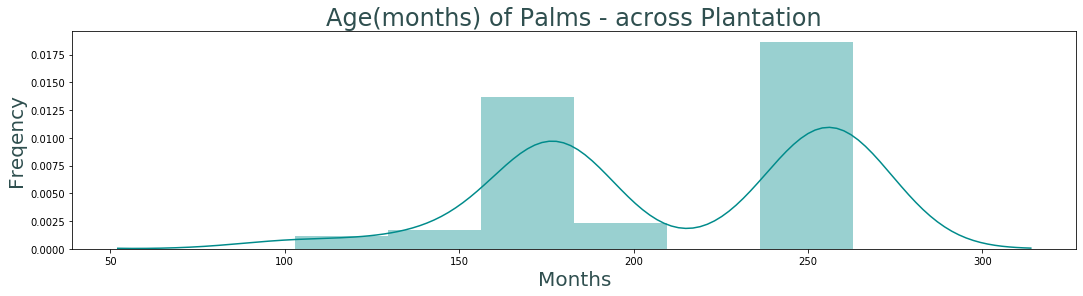

In [34]:

graph = blocks.copy()
xf=graph['age']
#yf=graph['']
#cf=graph['']
xlabel='Months'
ylabel='Freqency'
title = 'Age(months) of Palms - across Plantation'
fig, ax = plt.subplots(figsize=(18,4));
ax = sns.distplot(xf,norm_hist=True,color=my_graph_col);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

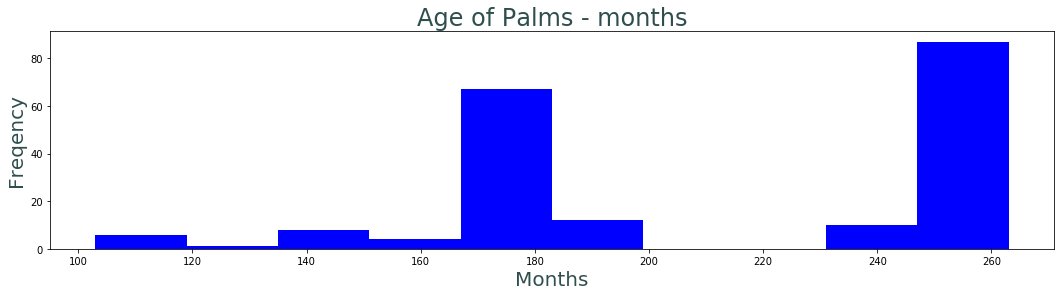

In [35]:
graph = blocks.copy()
xf=graph['age']
#yf=graph['']
#cf=graph['']
xlabel='Months'
ylabel='Freqency'
title = 'Age of Palms - months'
fig, ax = plt.subplots(figsize=(18,4))
ax = xf.plot(kind='hist',color = 'blue')
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

#### Plot - Class wise total proportion for Plantation

In [36]:
filter = blocks[['blk','syp1_prop','syp2_prop','syp3_prop','syp4_prop','syp5_prop']]
cols = ['syp1_prop','syp2_prop','syp3_prop','syp4_prop','syp5_prop']
g = pd.melt(filter, id_vars = ['blk'], value_vars=cols, var_name ='class',value_name='vals')
graph = pd.DataFrame(g.groupby(['class'])['vals'].sum())

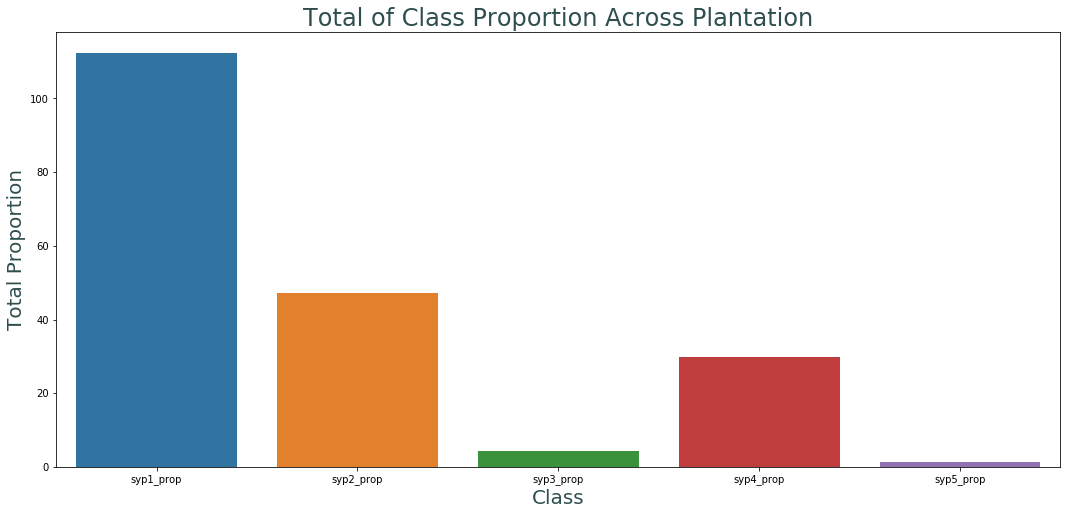

In [37]:
# Total of proportion of SYP class for all blocks
xf=graph.index
yf=graph['vals']
#cf=graph[]
xlabel='Class'
ylabel='Total Proportion'
title = 'Total of Class Proportion Across Plantation'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(x=xf, y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

#### Plot - Class wise total area across Plantation

In [38]:
filter = blocks[['blk','syp1_ha','syp2_ha','syp3_ha','syp4_ha','syp5_ha']]
cols = ['syp1_ha','syp2_ha','syp3_ha','syp4_ha','syp5_ha']
g = pd.melt(filter, id_vars = ['blk'], value_vars=cols, var_name ='class',value_name='area')
graph = pd.DataFrame(g.groupby(['class'])['area'].sum())

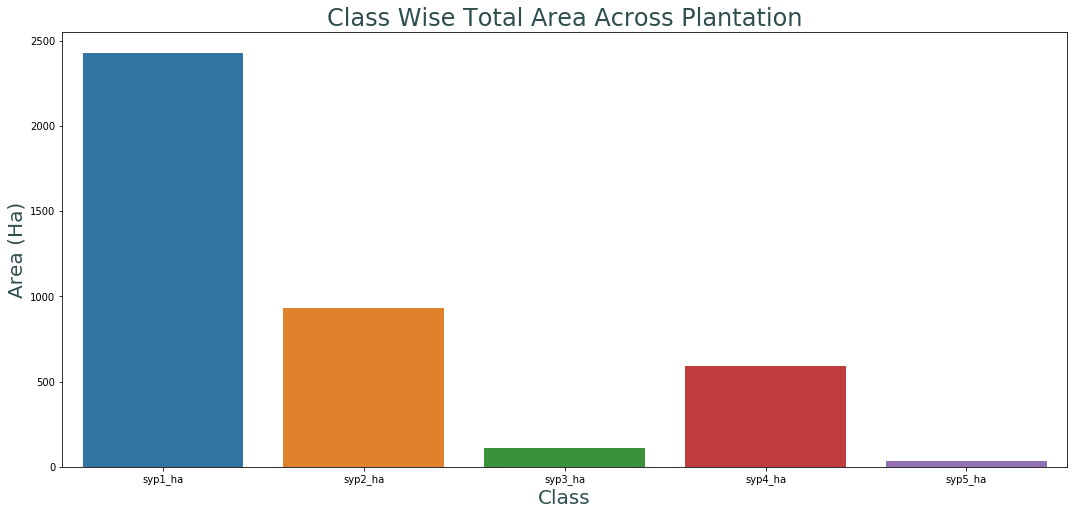

In [39]:
# blocks vs syp classes
xf=graph.index
yf=graph['area']
#cf=graph[]
xlabel='Class'
ylabel='Area (Ha)'
title = 'Class Wise Total Area Across Plantation'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(x=xf, y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

#### Plot - Age(months) vs Crop Yield across 10 years 

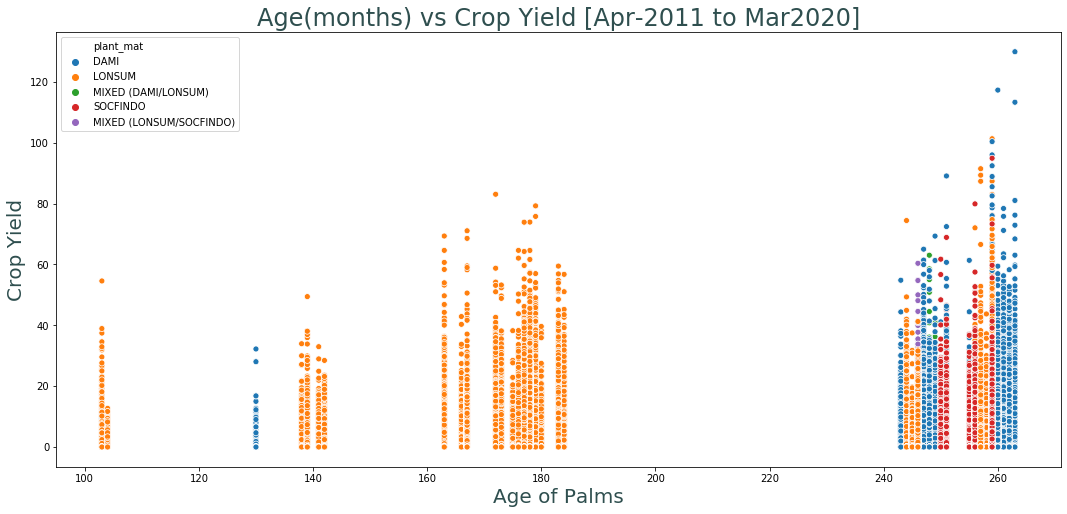

In [40]:
graph = dfi.copy()
xf=graph['age']
yf=graph['crop']
cf=graph['plant_mat']
xlabel='Age of Palms'
ylabel='Crop Yield'
title = 'Age(months) vs Crop Yield [Apr-2011 to Mar2020]'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,hue=cf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
plt.legend();

#### Plot - Age(months) vs Crop Yield for Year 2019

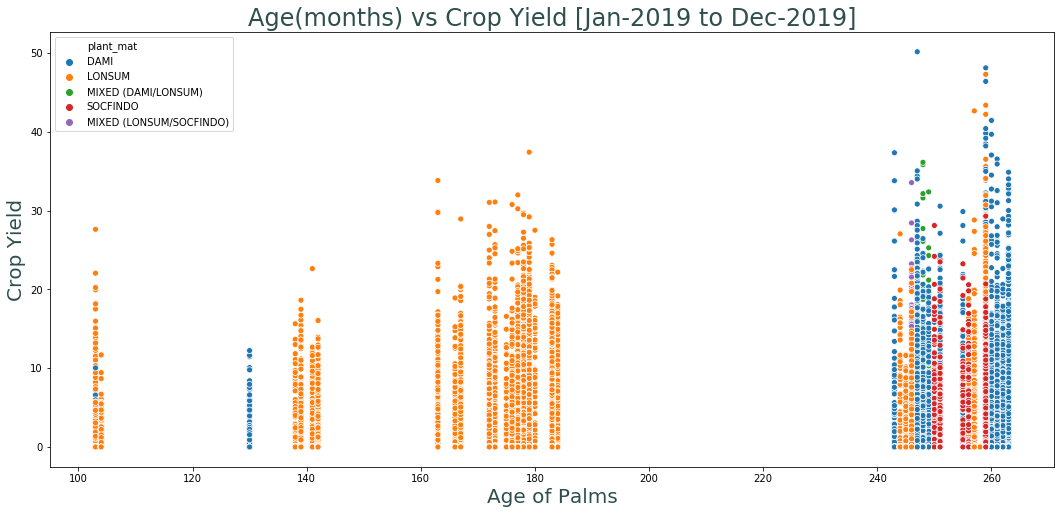

In [41]:
graph = dfi[dfi.index.year == 2019]
xf=graph['age']
yf=graph['crop']
cf=graph['plant_mat']
xlabel='Age of Palms'
ylabel='Crop Yield'
title = 'Age(months) vs Crop Yield [Jan-2019 to Dec-2019]'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.scatterplot(x=xf,y=yf,hue=cf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
plt.legend();

#### Plot - Species vs Number of Palms

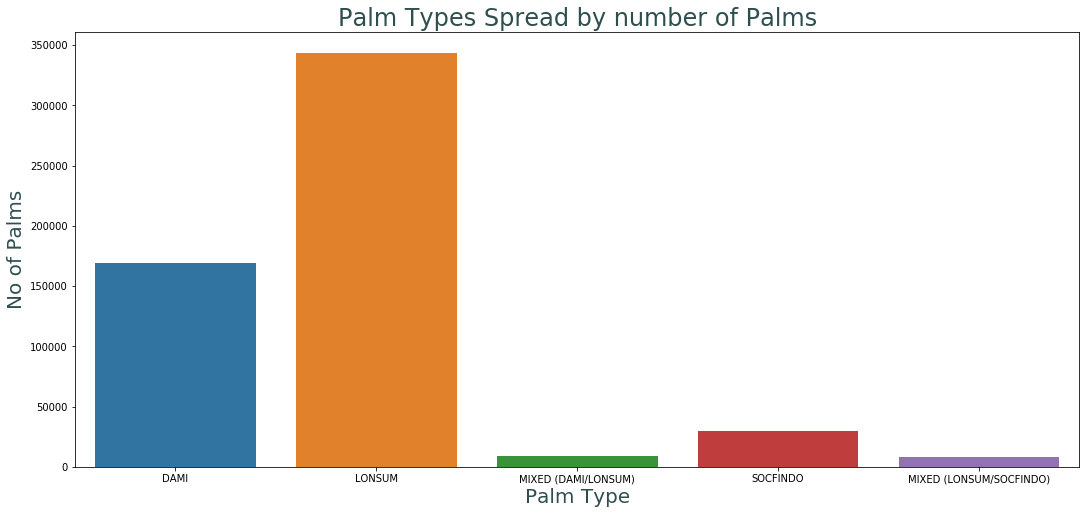

In [42]:
# Palm type spread
graph = blocks.copy()
xf=graph['plant_mat']
yf=graph['no_of_palms']
#cf=graph['']
xlabel='Palm Type'
ylabel='No of Palms'
title = 'Palm Types Spread by number of Palms'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(x=xf,y=yf,ci=None, estimator=sum);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

#### Plot - Species vs Age of Palms

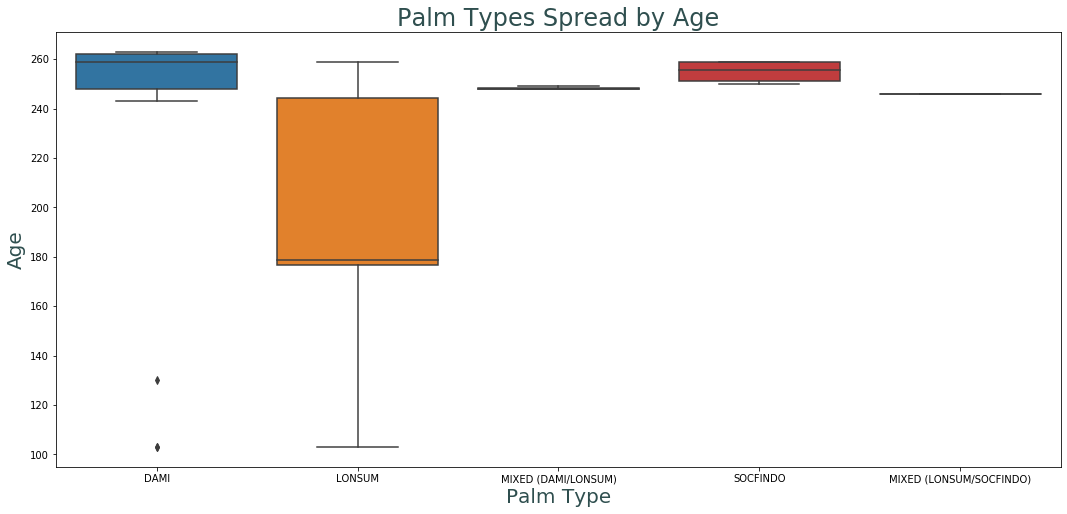

In [43]:
# Palm type spread by age
graph = blocks.copy()
xf=graph['plant_mat']
yf=graph['age']
#cf=graph['']
xlabel='Palm Type'
ylabel='Age'
title = 'Palm Types Spread by Age'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.boxplot(x=xf,y=yf);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

#### Plot - Species vs Crop Yield across 10 years

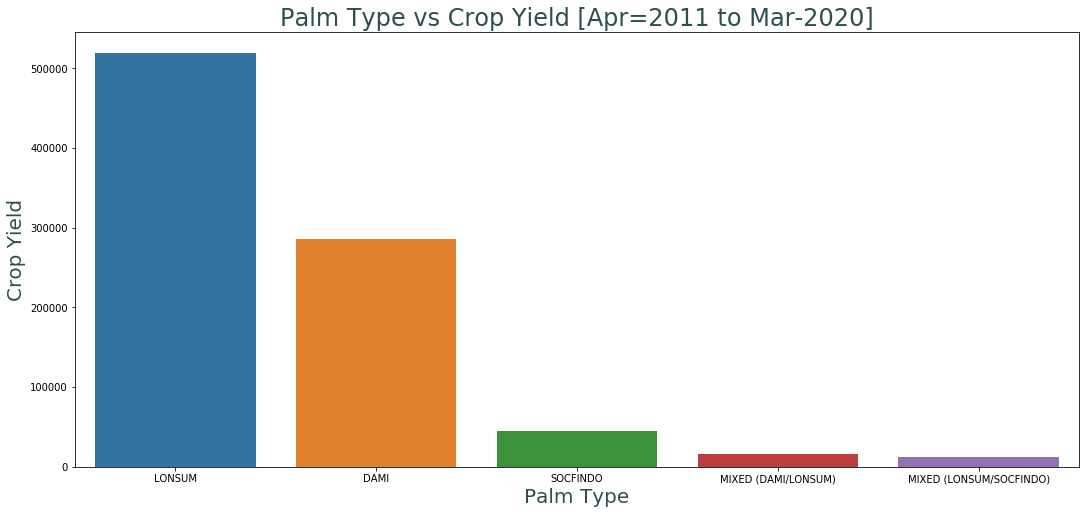

In [44]:
# Palm type crop yield 
graph = pd.DataFrame(dfi.groupby(['plant_mat'])['crop'].sum().sort_values(ascending=False))
xf=graph.index
yf=graph['crop']
#cf=graph['']
xlabel='Palm Type'
ylabel='Crop Yield'
title = 'Palm Type vs Crop Yield [Apr=2011 to Mar-2020]'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

#### Plot - Species vs Crop Yield for year 2019

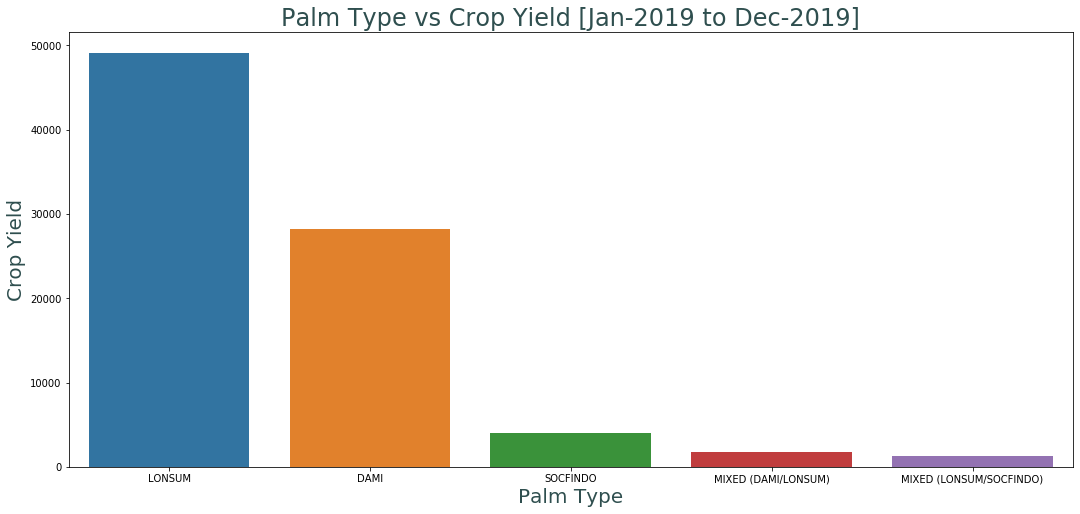

In [45]:
# Palm type crop yield for year 2019
filter = dfi[dfi.index.year == 2019]
graph = pd.DataFrame(filter.groupby(['plant_mat'])['crop'].sum().sort_values(ascending=False))
xf=graph.index
yf=graph['crop']
#cf=graph['']
xlabel='Palm Type'
ylabel='Crop Yield'
title = 'Palm Type vs Crop Yield [Jan-2019 to Dec-2019]'
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

#### Plot - Crop Yield vs No of Palms 

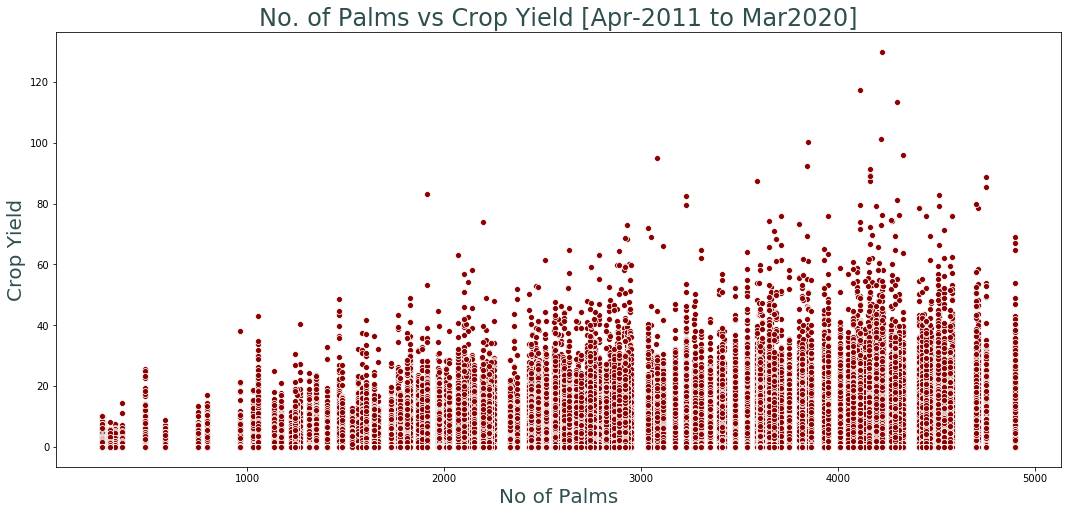

In [46]:
# for 10 year
graph = dfi.copy()
xf=graph['no_of_palms']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='No of Palms'
ylabel='Crop Yield'
title = 'No. of Palms vs Crop Yield [Apr-2011 to Mar2020]'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkred');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

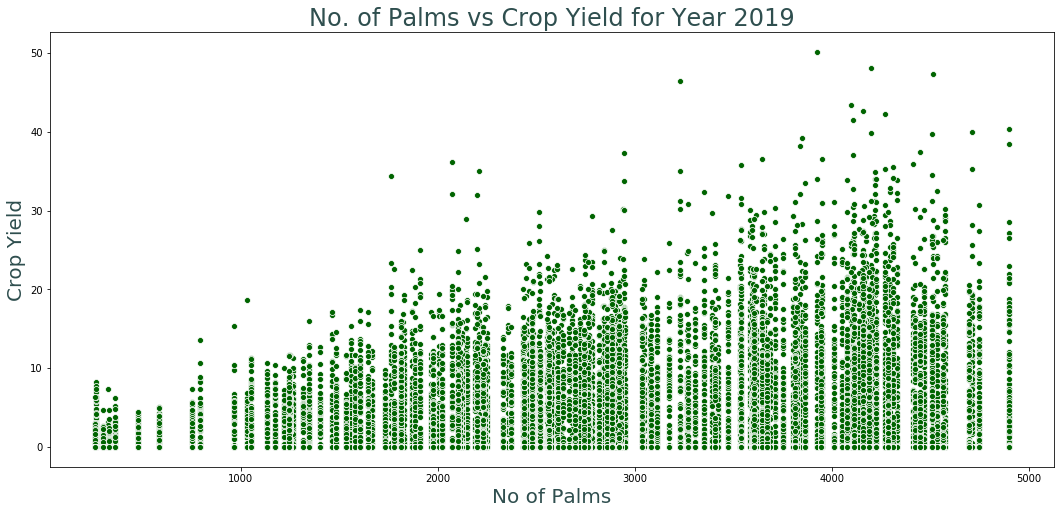

In [47]:
# for year 2019
graph = dfi[dfi.index.year == 2019]
xf=graph['no_of_palms']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='No of Palms'
ylabel='Crop Yield'
title = 'No. of Palms vs Crop Yield for Year 2019'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkgreen');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

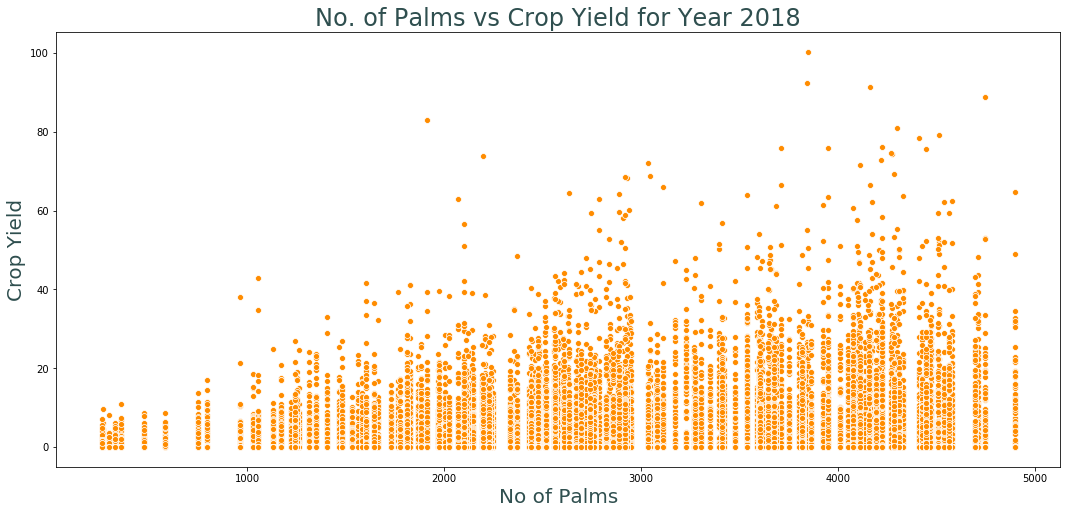

In [48]:
# for year 2018
graph = dfi[dfi.index.year == 2018]
xf=graph['no_of_palms']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='No of Palms'
ylabel='Crop Yield'
title = 'No. of Palms vs Crop Yield for Year 2018'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkorange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

#### Plot - Density Distribution

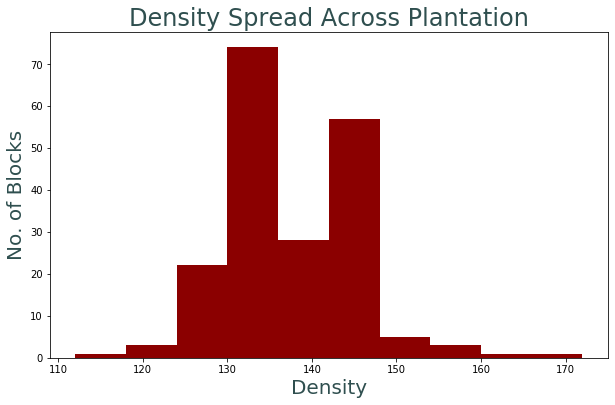

In [49]:
# for 10 year
graph = blocks.copy()
xf=graph['density']
#yf=graph['crop']
#cf=graph['plant_mat']
xlabel='Density'
ylabel='No. of Blocks'
title = 'Density Spread Across Plantation'
fig, ax = plt.subplots(figsize=(10,6));
blocks['density'].plot(kind='hist',color='darkred');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

#### Plot - Density Vs Crop

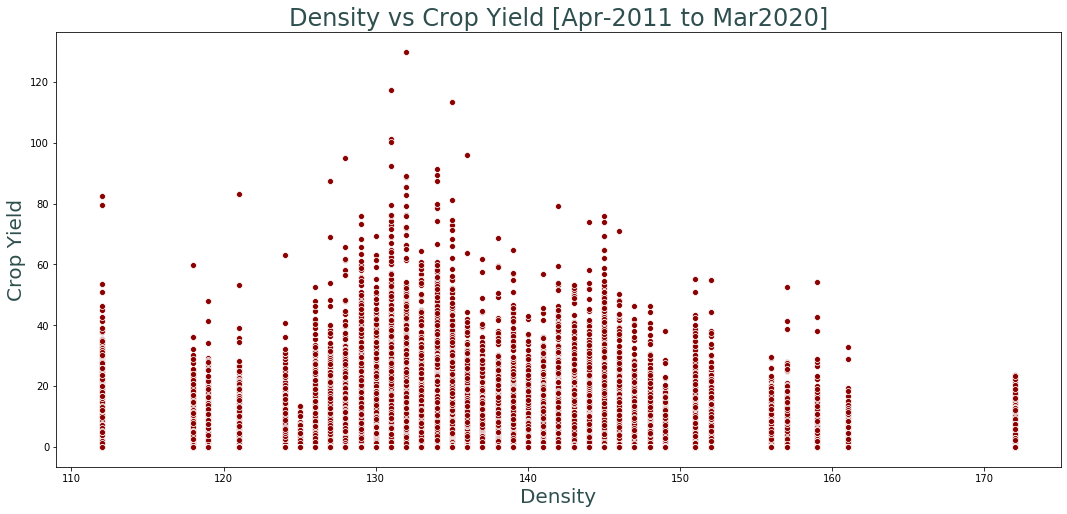

In [50]:
# for 10 year
graph = dfi.copy()
xf=graph['density']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='Density'
ylabel='Crop Yield'
title = 'Density vs Crop Yield [Apr-2011 to Mar2020]'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkred');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

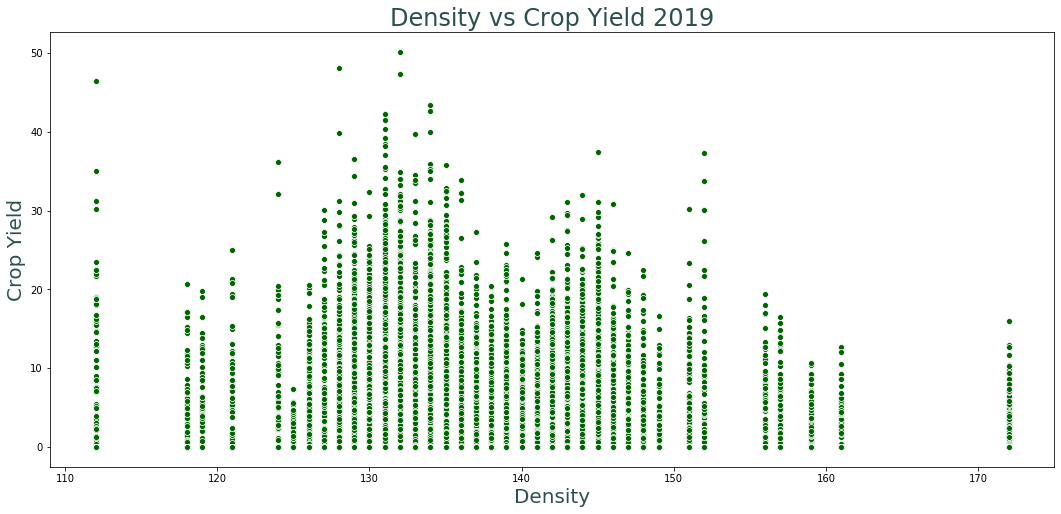

In [51]:
# for year 2019
graph = dfi[dfi.index.year == 2019]
xf=graph['density']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='Density'
ylabel='Crop Yield'
title = 'Density vs Crop Yield 2019'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkgreen');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

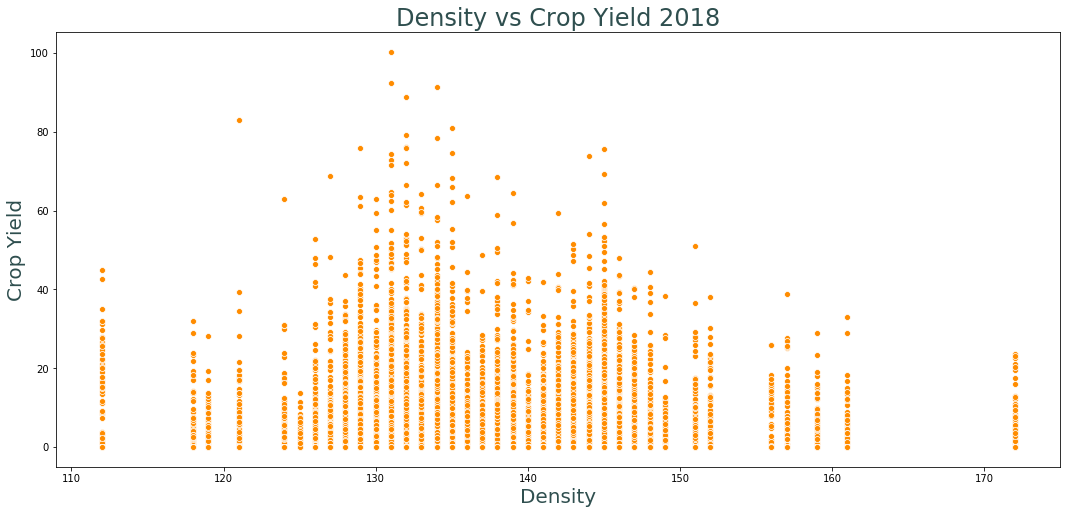

In [52]:
# for year 2018
graph = dfi[dfi.index.year == 2018]
xf=graph['density']
yf=graph['crop']
#cf=graph['plant_mat']
xlabel='Density'
ylabel='Crop Yield'
title = 'Density vs Crop Yield 2018'
fig, ax = plt.subplots(figsize=(18,8));
ax = sns.scatterplot(x=xf,y=yf,ci=None,color='darkorange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();

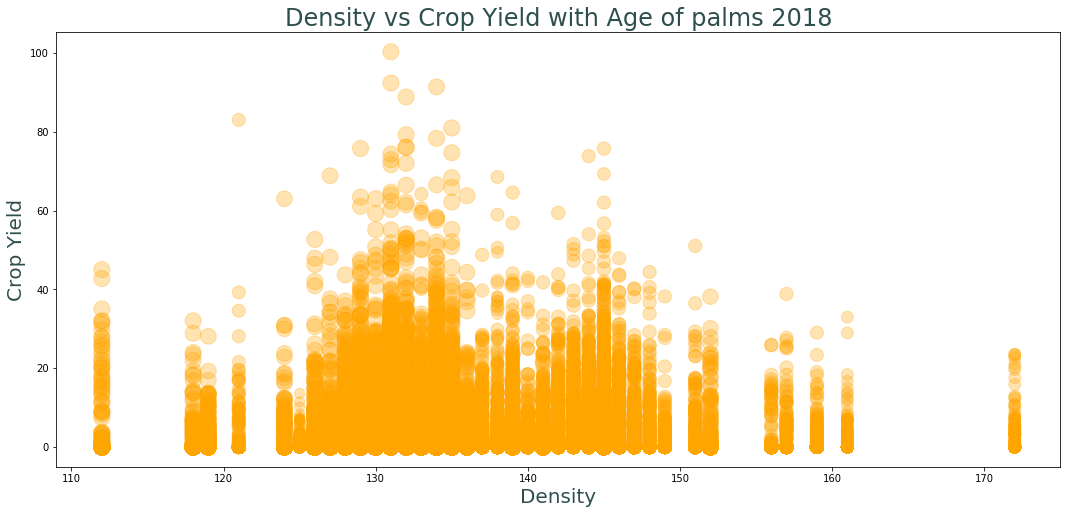

In [53]:
# for year 2018 overlayed with Age of the palms
graph = dfi[dfi.index.year == 2018]
xf=graph['density']
yf=graph['crop']
cf = graph['age']
xlabel='Density'
ylabel='Crop Yield'
title = 'Density vs Crop Yield with Age of palms 2018'

fig, ax = plt.subplots(figsize=(18,8));
plt.scatter(xf, yf, s=cf, alpha=0.3,color='orange')
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
#plt.legend();
plt.show();

In [54]:
blocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blk           195 non-null    object 
 1   plant_mat     195 non-null    object 
 2   area_ha       195 non-null    float64
 3   no_of_palms   195 non-null    int64  
 4   mth_of_plant  195 non-null    object 
 5   syp1_ha       195 non-null    float64
 6   syp1_prop     195 non-null    float64
 7   syp2_ha       195 non-null    float64
 8   syp2_prop     195 non-null    float64
 9   syp3_ha       195 non-null    float64
 10  syp3_prop     195 non-null    float64
 11  syp4_ha       195 non-null    float64
 12  syp4_prop     195 non-null    float64
 13  syp5_ha       195 non-null    float64
 14  syp5_prop     195 non-null    float64
 15  age           195 non-null    int64  
 16  density       195 non-null    int64  
dtypes: float64(11), int64(3), object(3)
memory usage: 26.0+ KB


#### Plot - Blocks vs No. Palms

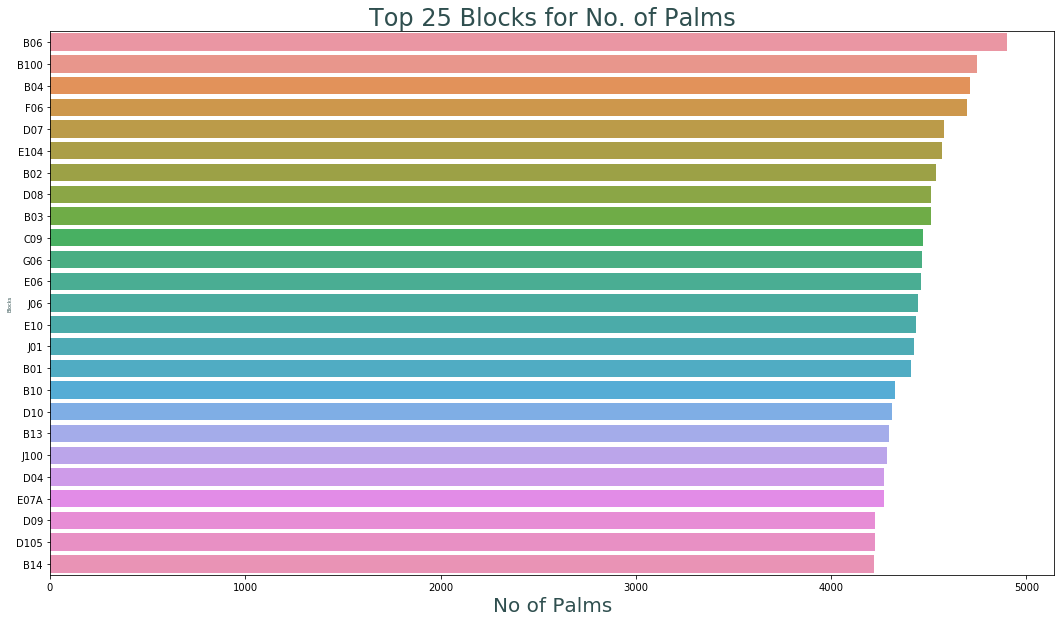

In [55]:
# Blockwise no of palms
graph = pd.DataFrame(blocks.groupby(['blk'])['no_of_palms'].sum().sort_values(ascending=False)).head(25)
xf=graph['no_of_palms']
yf=graph.index
#cf=graph['']
xlabel='No of Palms'
ylabel='Blocks'
title = 'Top 25 Blocks for No. of Palms'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

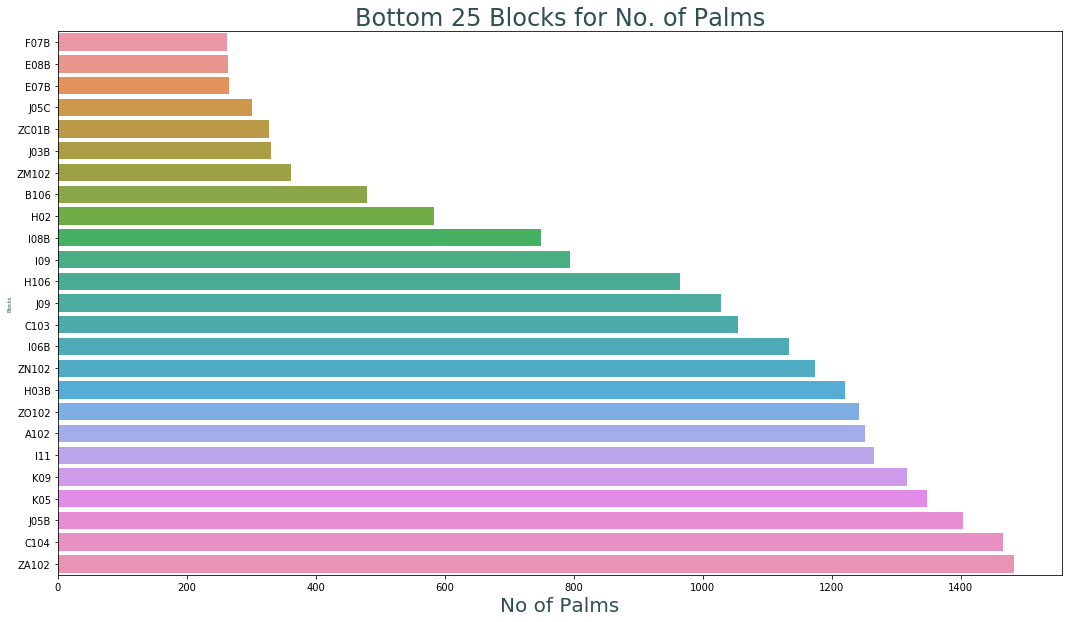

In [56]:
# Blockwise no of palms
graph = pd.DataFrame(blocks.groupby(['blk'])['no_of_palms'].sum().sort_values(ascending=True)).head(25)
xf=graph['no_of_palms']
yf=graph.index
#cf=graph['']
xlabel='No of Palms'
ylabel='Blocks'
title = 'Bottom 25 Blocks for No. of Palms'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

#### Plot - Blocks wise Density

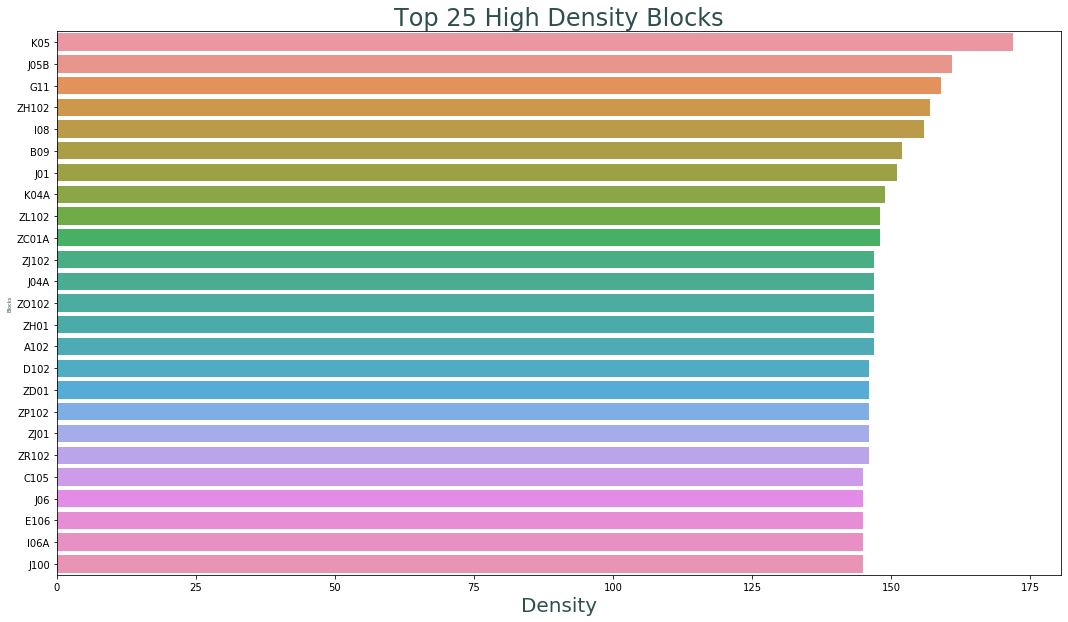

In [57]:
#Top 25 highest Density blocks
graph = pd.DataFrame(blocks.groupby(['blk'])['density'].sum().sort_values(ascending=False)).head(25)
xf=graph['density']
yf=graph.index
#cf=graph['']
xlabel='Density'
ylabel='Blocks'
title = 'Top 25 High Density Blocks'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

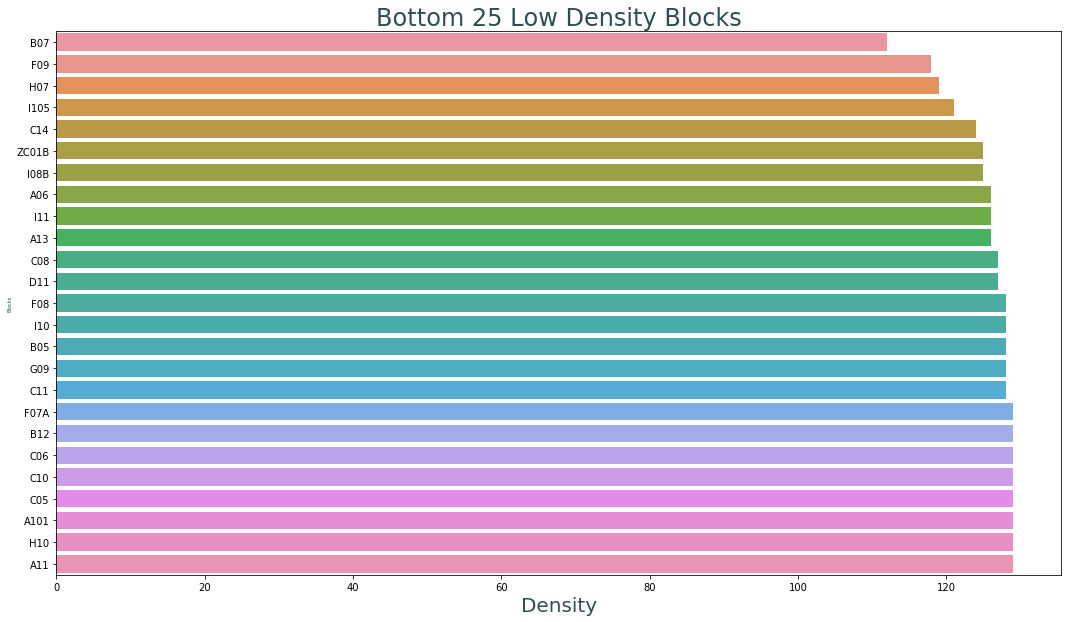

In [58]:
# Bottom 25 Blockwise Density
graph = pd.DataFrame(blocks.groupby(['blk'])['density'].sum().sort_values(ascending=True)).head(25)
xf=graph['density']
yf=graph.index
#cf=graph['']
xlabel='Density'
ylabel='Blocks'
title = 'Bottom 25 Low Density Blocks'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

#### Plot - Blocks wise Crop Yield

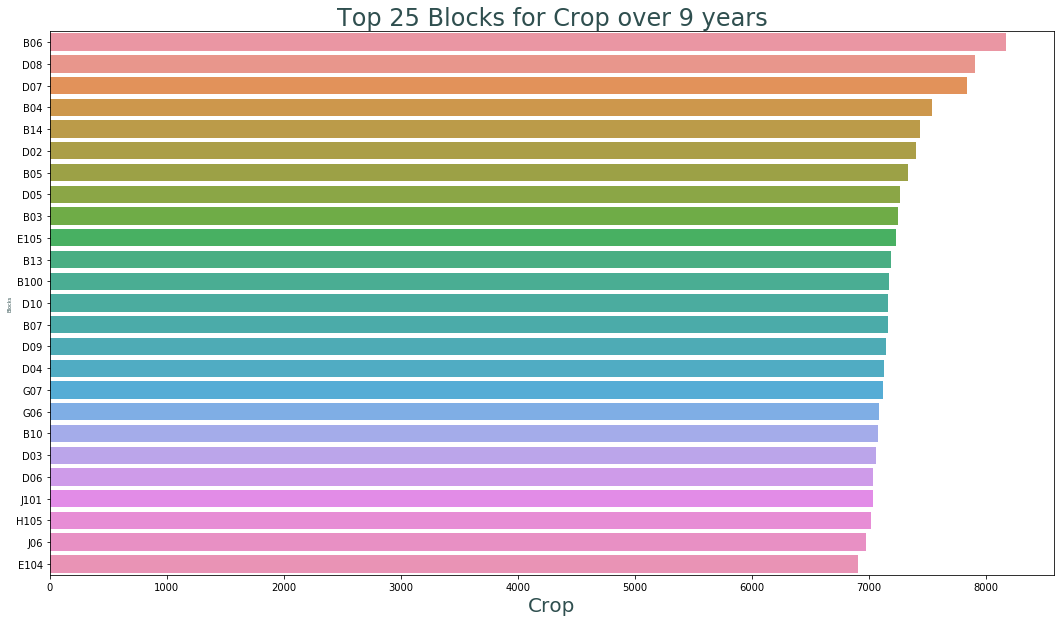

In [59]:
filter = dfi.copy()
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=False)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Top 25 Blocks for Crop over 9 years'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

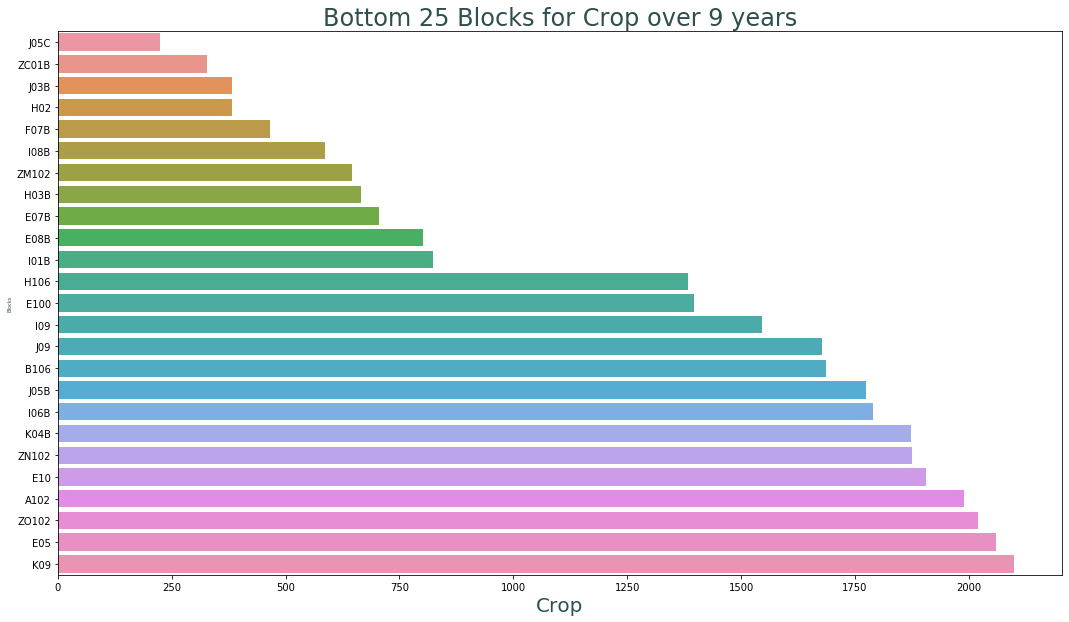

In [60]:
filter = dfi.copy()
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=True)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Bottom 25 Blocks for Crop over 9 years'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

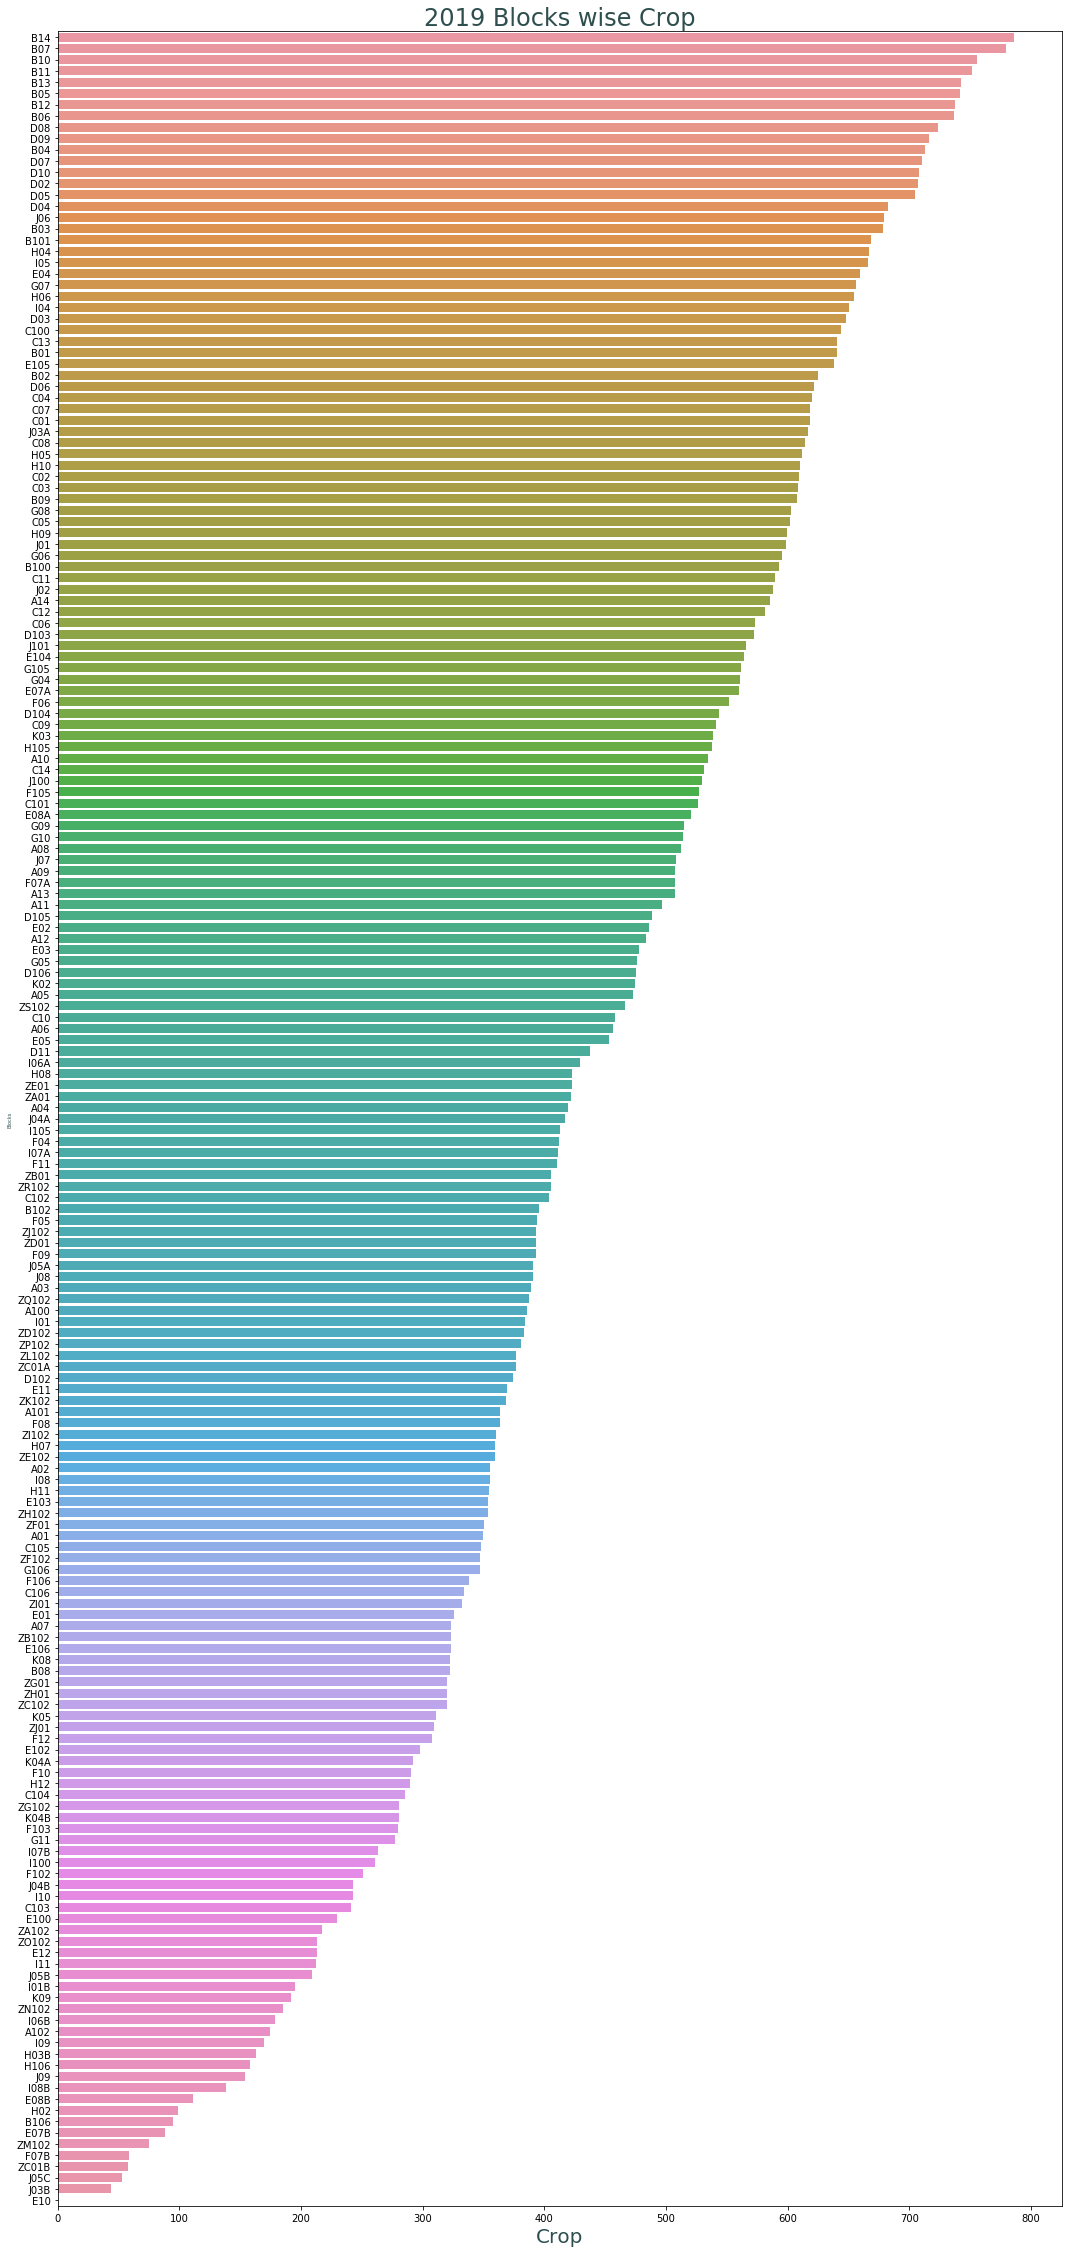

In [61]:
# Blockwise crop yield in year 2019
filter = dfi[dfi.index.year == 2019]
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=False))
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = '2019 Blocks wise Crop'
fig, ax = plt.subplots(figsize=(18,40))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 5);

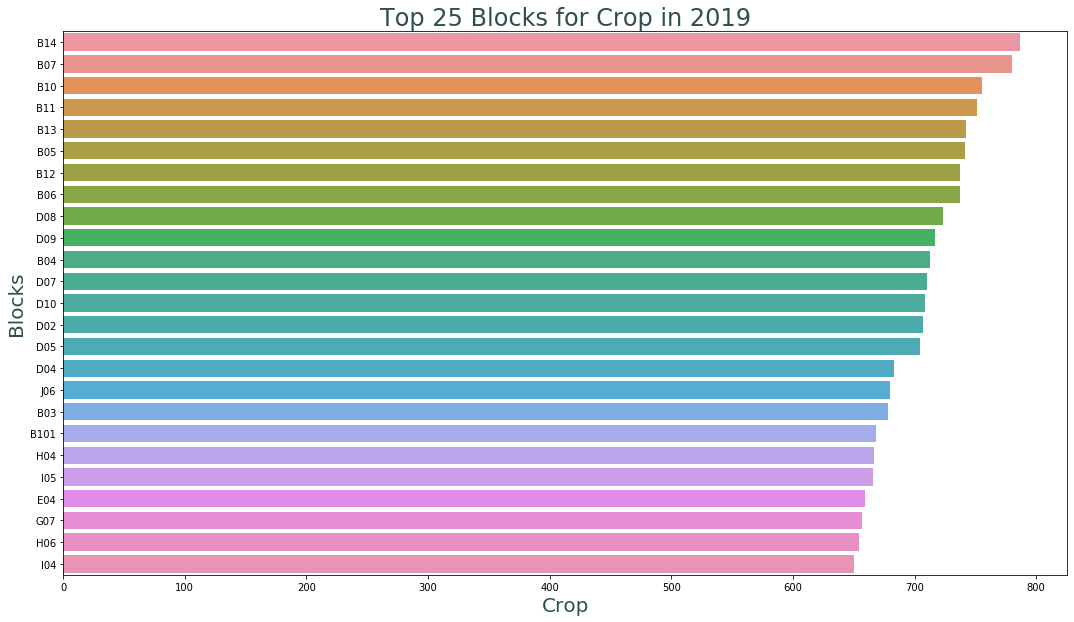

In [62]:
# Top 25 Blocks in crop yeild for 2019
filter = dfi[dfi.index.year == 2019]
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=False)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Top 25 Blocks for Crop in 2019'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

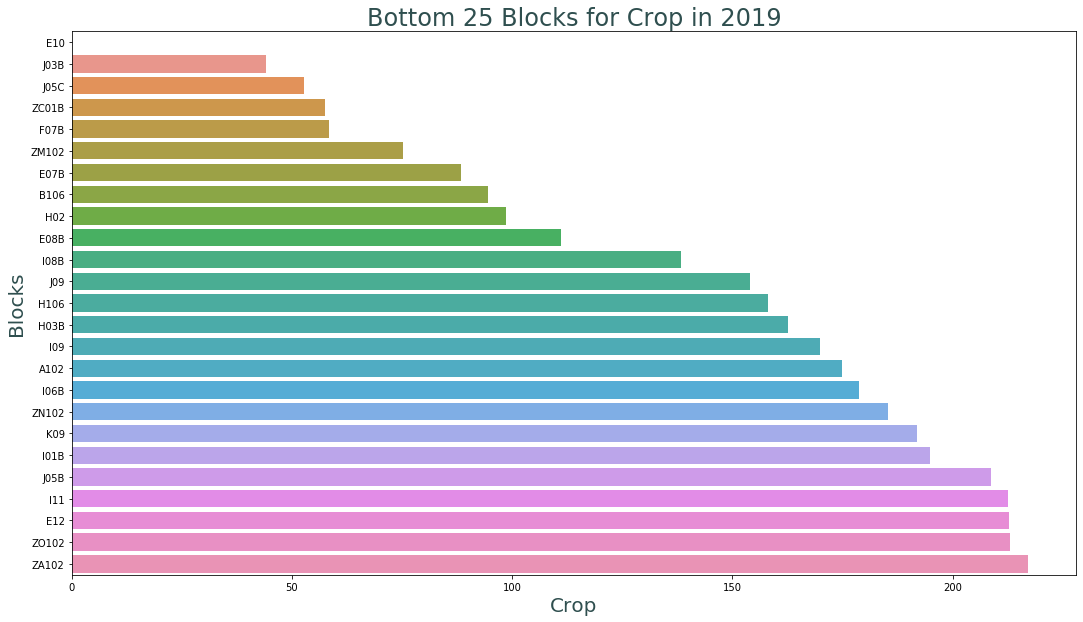

In [63]:
# Bottom 25 Blocks in crop yeild for 2019
filter = dfi[dfi.index.year == 2019]
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=True)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Bottom 25 Blocks for Crop in 2019'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

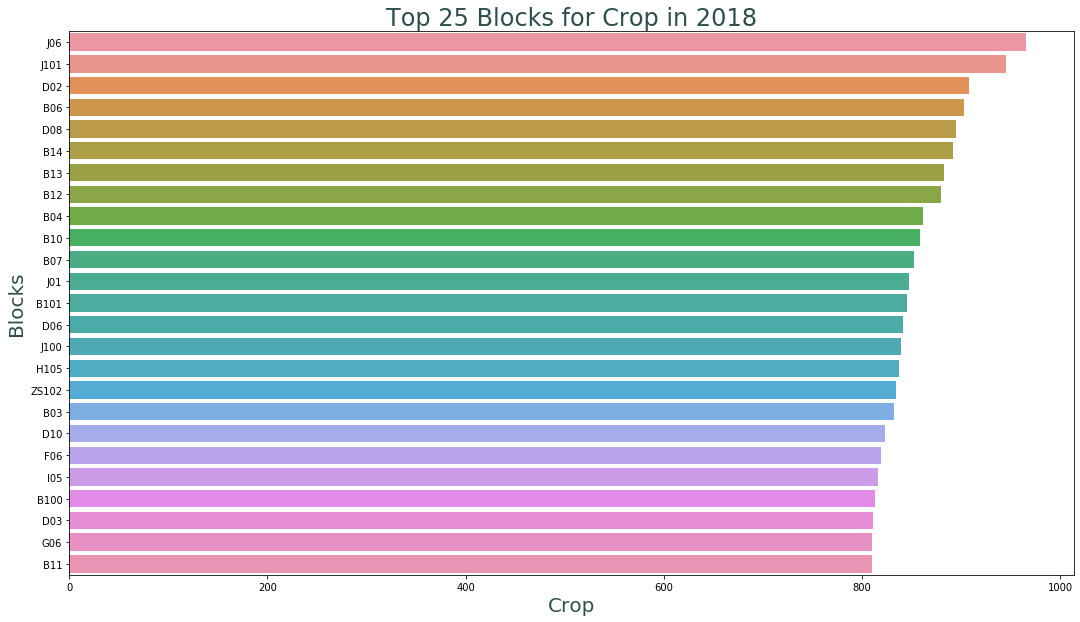

In [64]:
# Top 25 Blocks in crop yeild for 2018
filter = dfi[dfi.index.year == 2018]
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=False)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Top 25 Blocks for Crop in 2018'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

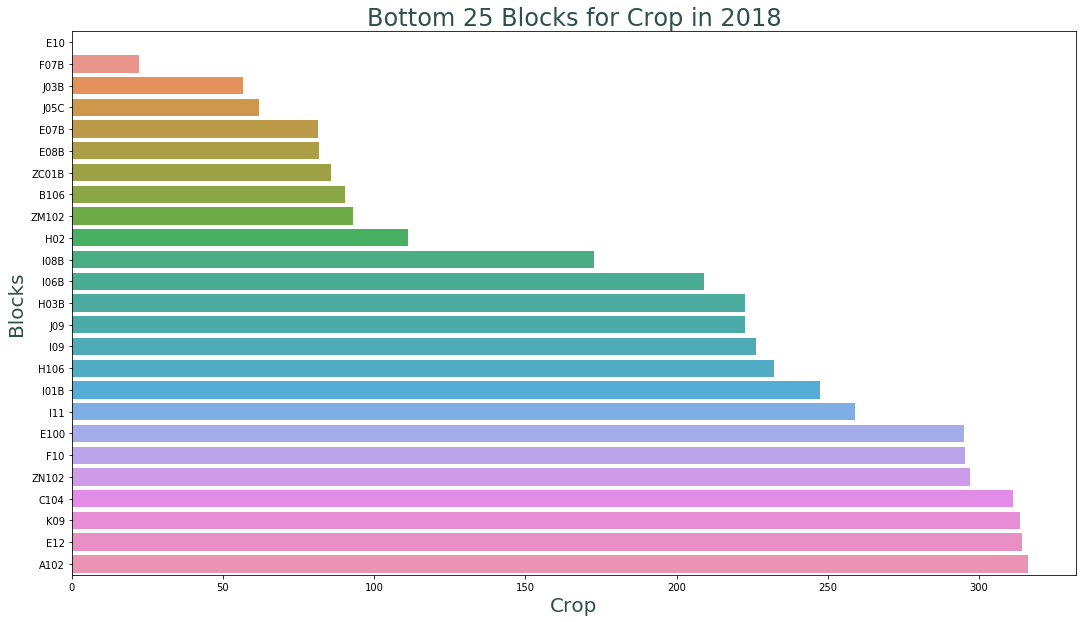

In [65]:
# Bottom 25 Blocks in crop yeild for 2018
filter = dfi[dfi.index.year == 2018]
graph = pd.DataFrame(filter.groupby(['blk'])['crop'].sum().sort_values(ascending=True)).head(25)
xf=graph['crop']
yf=graph.index
#cf=graph['']
xlabel='Crop'
ylabel='Blocks'
title = 'Bottom 25 Blocks for Crop in 2018'
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.barplot(x=xf,y=yf,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

### Analysis of rain and crop trends

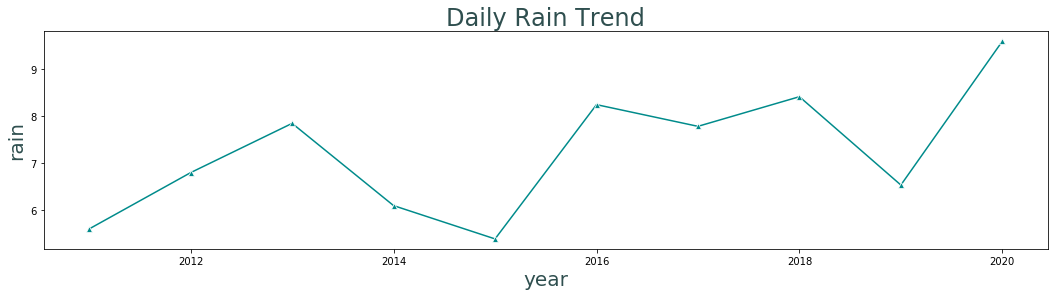

In [66]:

graph = dfi.copy()
xf=graph.index.year
yf=graph['rain']
#cf=graph['']
xlabel='year'
ylabel='rain'
title = 'Daily Rain Trend'
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.lineplot(x=xf,y=yf,color=my_graph_col,ci=None,marker="^");
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

In [67]:
dfi.groupby(['blk'])['crop'].sum()

blk
A01      4100.38948
A02      4137.95578
A03      4477.99113
A04      4689.57623
A05      4722.79415
A06      4759.41960
A07      3276.80454
A08      4923.37442
A09      4997.21394
A10      5027.06216
A100     4304.60196
A101     4051.02956
A102     1988.26440
A11      5046.54971
A12      4857.96758
A13      5227.87728
A14      5336.93208
B01      6899.42324
B02      6822.04065
B03      7249.18640
B04      7536.88939
B05      7332.81391
B06      8173.00033
B07      7158.43934
B08      2967.53636
B09      5464.63753
B10      7074.82372
B100     7172.12620
B101     6419.89360
B102     4383.73029
B106     1685.67474
B11      6908.37748
B12      6775.70585
B13      7184.57728
B14      7435.77642
C01      6358.74894
C02      6362.69956
C03      5893.98266
C04      5849.54258
C05      6031.18853
C06      6016.38309
C07      6034.95867
C08      5888.68190
C09      6293.70877
C10      3723.71902
C100     6668.04182
C101     4317.79491
C102     4871.33744
C103     3225.25502
C104     3772.20

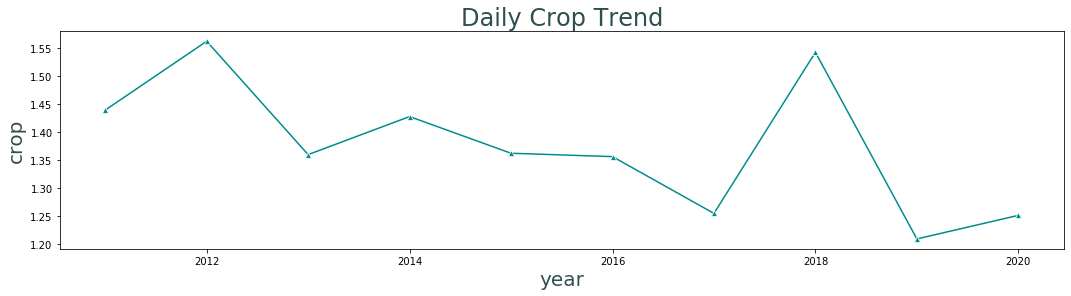

In [68]:

graph = dfi.copy()
xf=graph.index.year
yf=graph['crop']
#cf=graph['']
xlabel='year'
ylabel='crop'
title = 'Daily Crop Trend'
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.lineplot(x=xf,y=yf,color=my_graph_col,ci=None,estimator='mean',marker='^');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

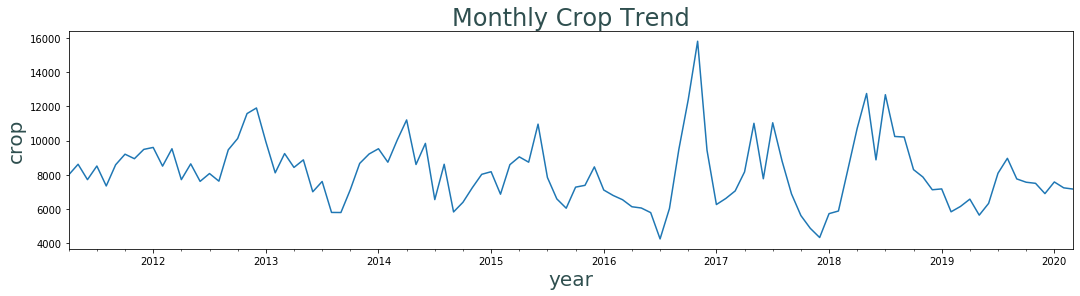

In [69]:
# monthly trend using resampled df_m dataframe
graph = df_m.copy()
xf=graph.index.year
yf=graph['crop']
#cf=graph['']
xlabel='year'
ylabel='crop'
title = 'Monthly Crop Trend'
fig, ax = plt.subplots(figsize=(18,4))
ax = df_m['crop'].plot();
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

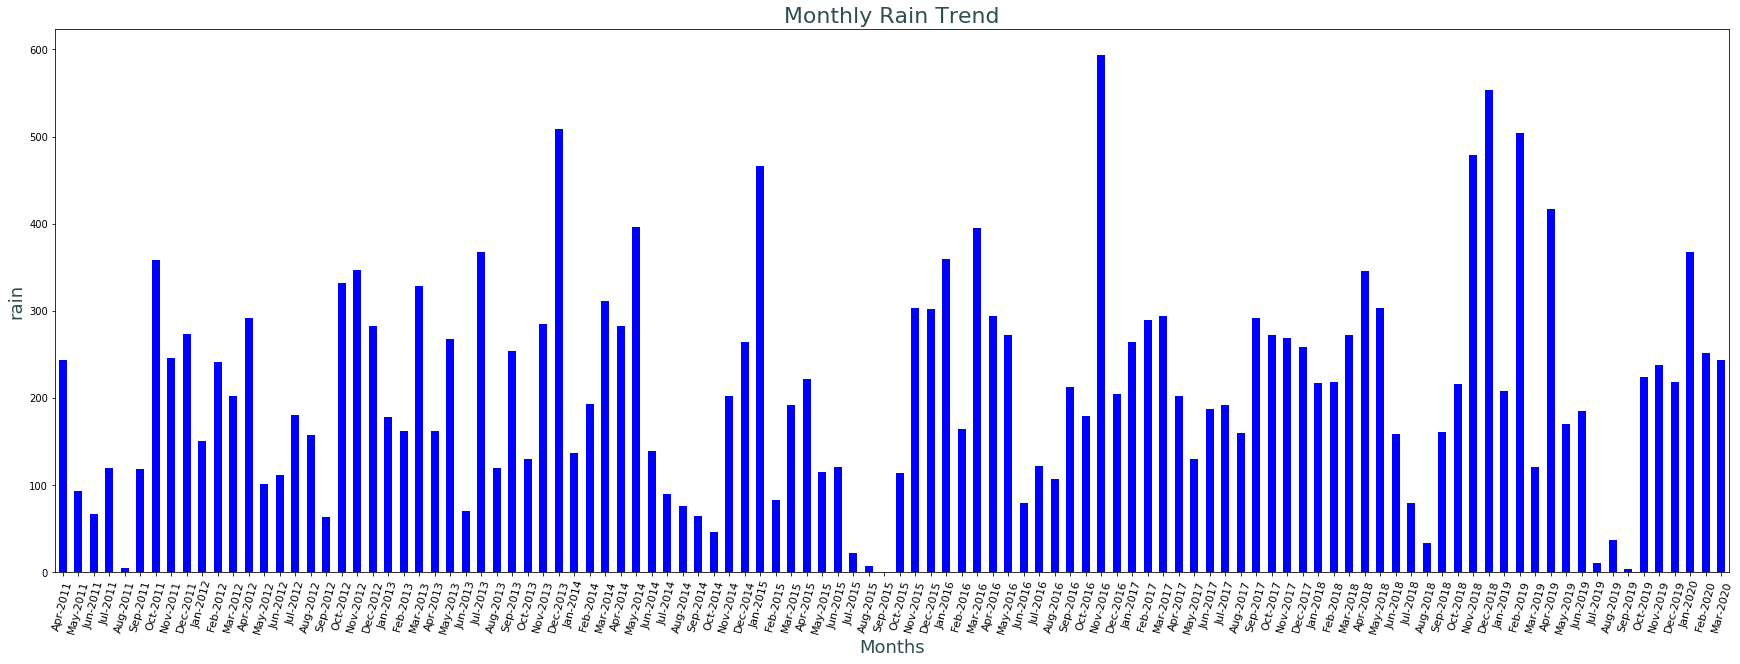

In [70]:
# monthly rain trend using resampled df_m dataframe
#graph = df_m.copy()
m_list = [m for m in df_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
xlabel='Months'
ylabel='rain'
title = 'Monthly Rain Trend'
fig, ax = plt.subplots(figsize=(30,10))
ax = df_m['rain'].plot(kind='bar',color='blue');
ax.set_title(title,color=my_title_col, fontsize = 22);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 18);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 18);
ax.set_xticklabels(m_list,fontsize=11,rotation=75);
plt.show()

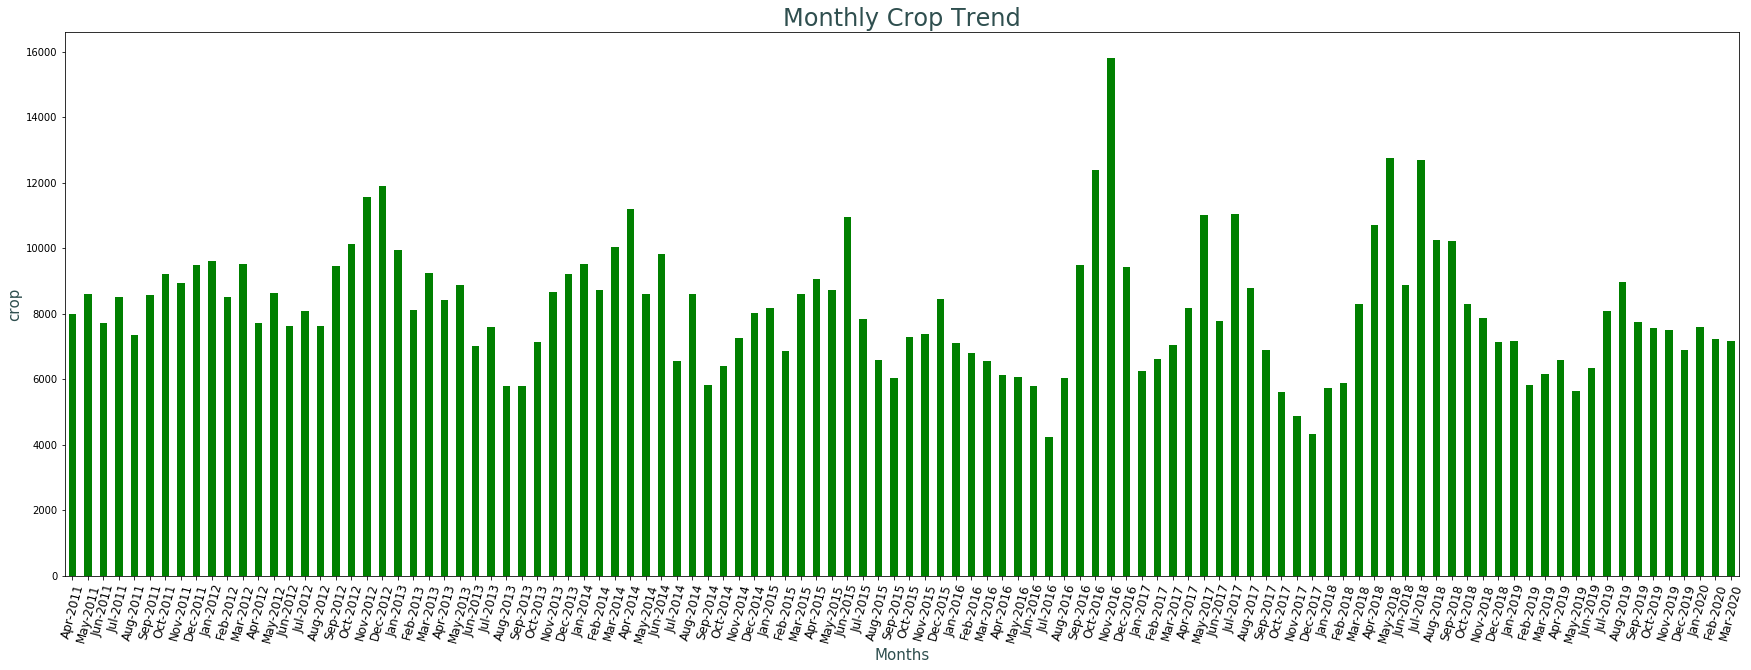

In [71]:
# monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
m_list = [m for m in df_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
xlabel='Months'
ylabel='crop'
title = 'Monthly Crop Trend'
fig, ax = plt.subplots(figsize=(30,10))
ax = df_m['crop'].plot(kind='bar',color='green');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.show()

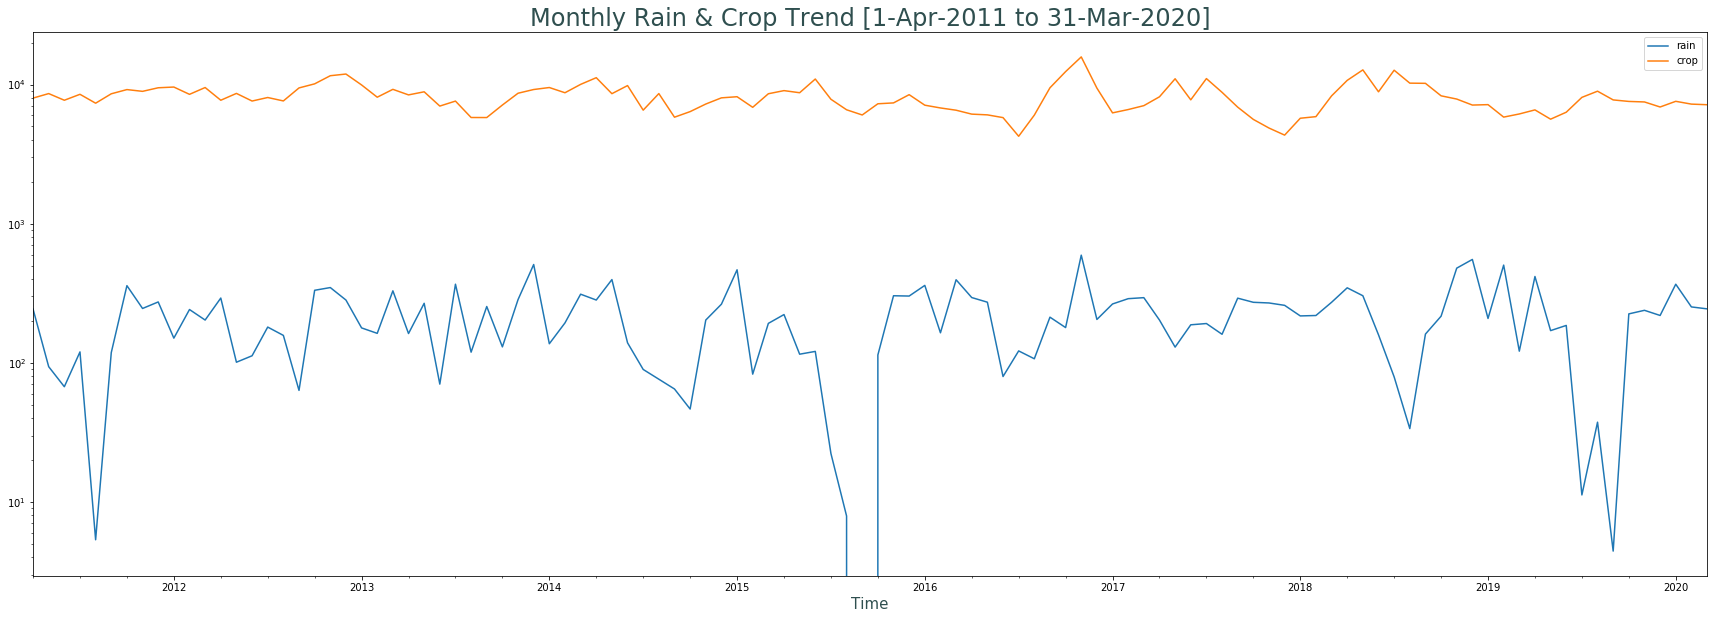

In [72]:
# trends line for last 10 years
# monthly rain trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in df_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
xlabel='Time'
ylabel=''
title = 'Monthly Rain & Crop Trend [1-Apr-2011 to 31-Mar-2020]'
fig, ax = plt.subplots(figsize=(30,10))
ax = df_m['rain'].plot(kind='line');
ax = df_m['crop'].plot(kind='line');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#x.set_xticklabels(m_list,fontsize=12,rotation=75);
ax.set_yscale('log');
ax.legend();
plt.show();



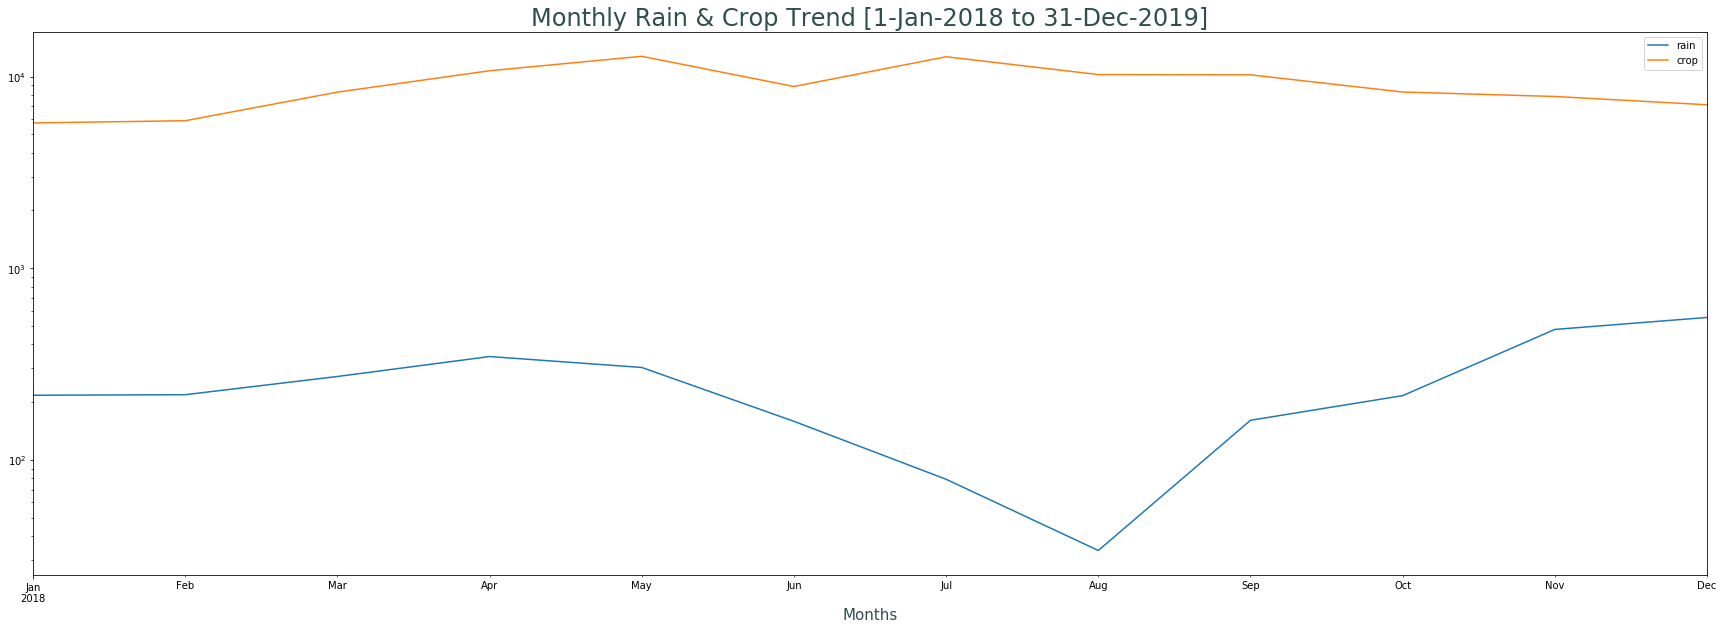

In [73]:
# trends line for last 2 years
df_m_18_19 = df_m[df_m.index.year == 2019 & 2018]

# monthly rain trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in df_m_19['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
xlabel='Months'
ylabel=''
title = 'Monthly Rain & Crop Trend [1-Jan-2018 to 31-Dec-2019]'
fig, ax = plt.subplots(figsize=(30,10))
ax = df_m_18_19['rain'].plot(kind='line');
ax = df_m_18_19['crop'].plot(kind='line');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#x.set_xticklabels(m_list,fontsize=12,rotation=75);
ax.set_yscale('log');
ax.legend();
plt.show();




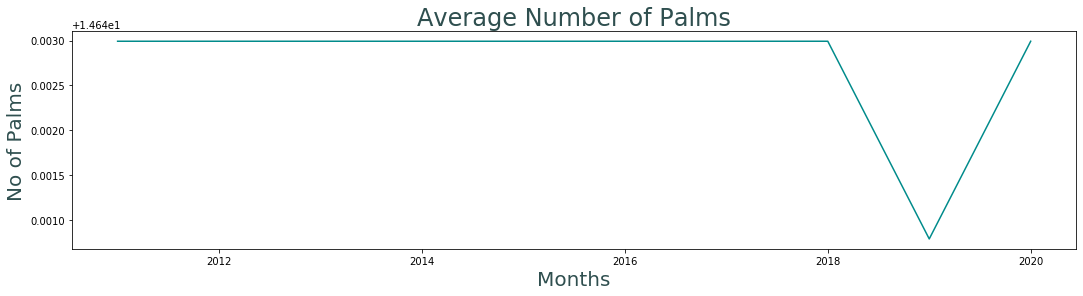

In [74]:

graph = dfi.copy()
xf=graph.index.year
yf=graph['no_of_palms']/195
#cf=graph['']
xlabel='Months'
ylabel='No of Palms'
title = 'Average Number of Palms'
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.lineplot(x=xf,y=yf,color=my_graph_col,ci=None);
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylim=(0,100000);
#ax.set_yscale('');

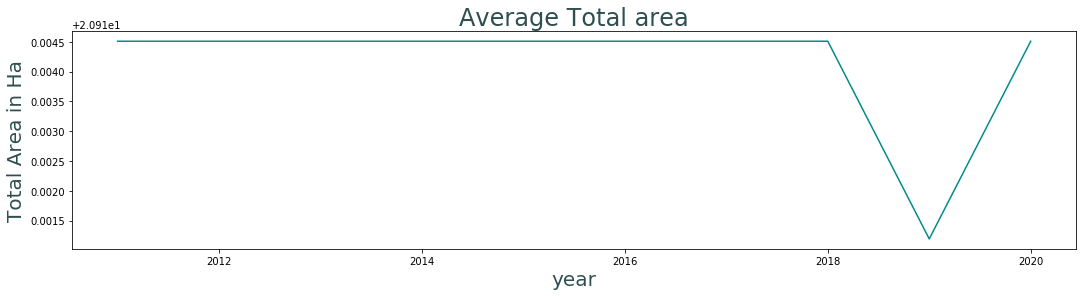

In [75]:
# Scatter plot to visually reflect the corrrelation between sales price and Overall Qual. 
graph = dfi.copy()
xf=graph.index.year
yf=graph['area_ha']
#cf=graph['']
xlabel='year'
ylabel='Total Area in Ha'
title = 'Average Total area'
fig, ax = plt.subplots(figsize=(18,4))
ax = sns.lineplot(x=xf,y=yf,color=my_graph_col,ci=None,estimator='mean');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = my_label_font);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = my_label_font);

### Analsysis of selected Blocks 
**Block B14 which had maximun crop yield in 2019**

In [76]:
b14 = dfi.copy()
b14 = b14[b14['blk'] == 'B14']
# monthly rain & crop data for B14
b14_m = b14[['rain','crop']].resample('M').sum()
b14_m['date'] = b14_m.index.date
b14_m['date'] = b14_m['date'].apply(lambda x: str(x))
b14_m['date'] = pd.to_datetime(b14_m['date'],yearfirst=True,format="%Y/%m") 
b14_m['month'] = b14_m['date'].apply(lambda x: x.strftime("%b-%Y"))# converting to name of the months and year
b14_m.head()

,rain,crop,date,month
date,,,,
2011-04-30,245.90,60.94714,2011-04-30,Apr-2011
2011-05-31,94.75,72.24748,2011-05-31,May-2011
2011-06-30,68.00,47.76973,2011-06-30,Jun-2011
2011-07-31,121.00,84.17281,2011-07-31,Jul-2011
2011-08-31,5.40,63.94344,2011-08-31,Aug-2011


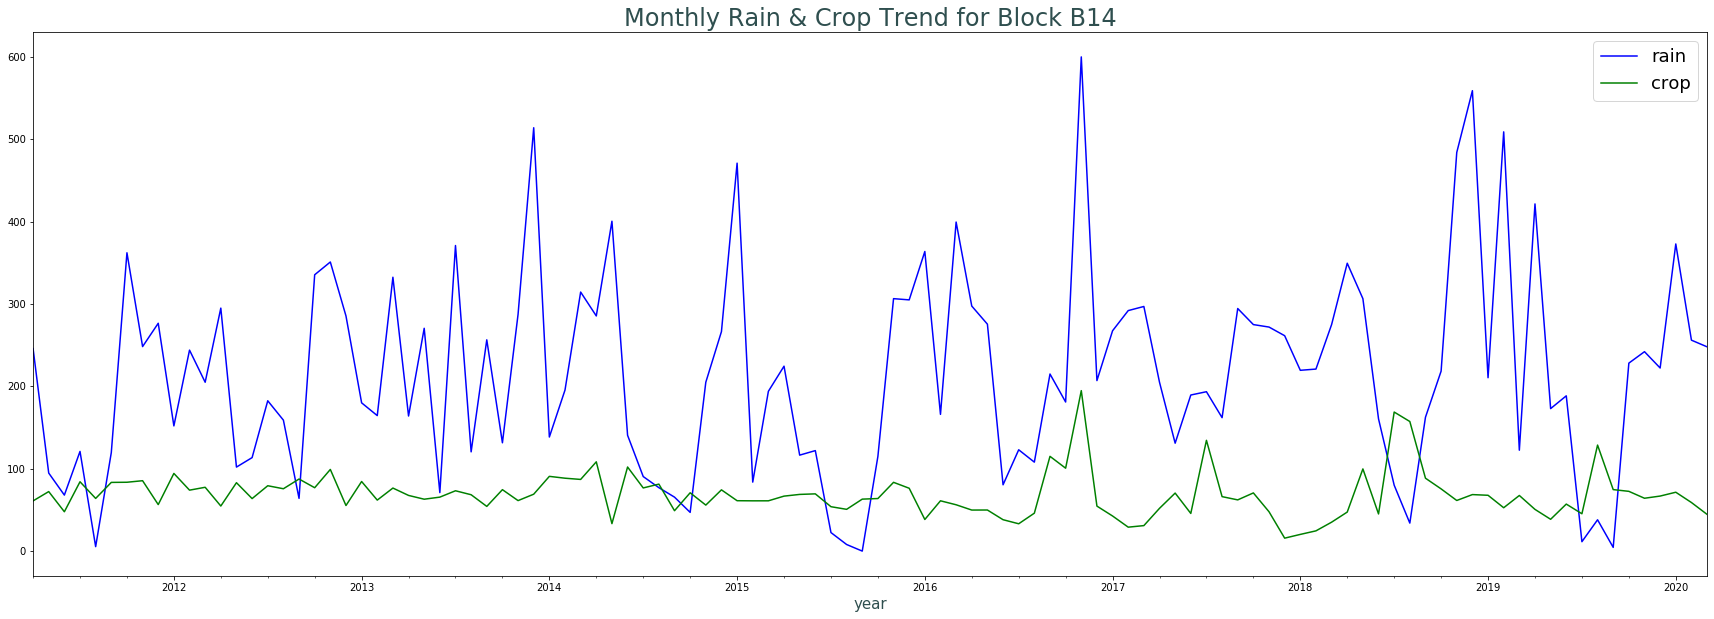

In [77]:
# for Blocks B14 : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in df_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
#xlabel='Months'
#ylabel='rain'
title = 'Monthly Rain & Crop Trend for Block B14'
fig, ax = plt.subplots(figsize=(30,10))
b14_m['rain'].plot(kind='line',color='blue');
b14_m['crop'].plot(kind='line',color='green');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.legend(fontsize=18);
plt.show();

**Block J04b which is 25 from the bottom for crop yield in 2019**

In [78]:
j04b = dfi.copy()
j04b = j04b[j04b['blk'] == 'J04B']
# monthly rain & crop data for B14
j04b_m = j04b[['rain','crop']].resample('M').sum()
j04b_m['date'] = j04b_m.index.date
j04b_m['date'] = j04b_m['date'].apply(lambda x: str(x))
j04b_m['date'] = pd.to_datetime(j04b_m['date'],yearfirst=True,format="%Y/%m") 
j04b_m['month'] = j04b_m['date'].apply(lambda x: x.strftime("%b-%Y"))# converting to name of the months and year
j04b_m.head()

,rain,crop,date,month
date,,,,
2011-04-30,245.90,1.73195,2011-04-30,Apr-2011
2011-05-31,94.75,1.45333,2011-05-31,May-2011
2011-06-30,68.00,4.23174,2011-06-30,Jun-2011
2011-07-31,121.00,6.00886,2011-07-31,Jul-2011
2011-08-31,5.40,6.14907,2011-08-31,Aug-2011


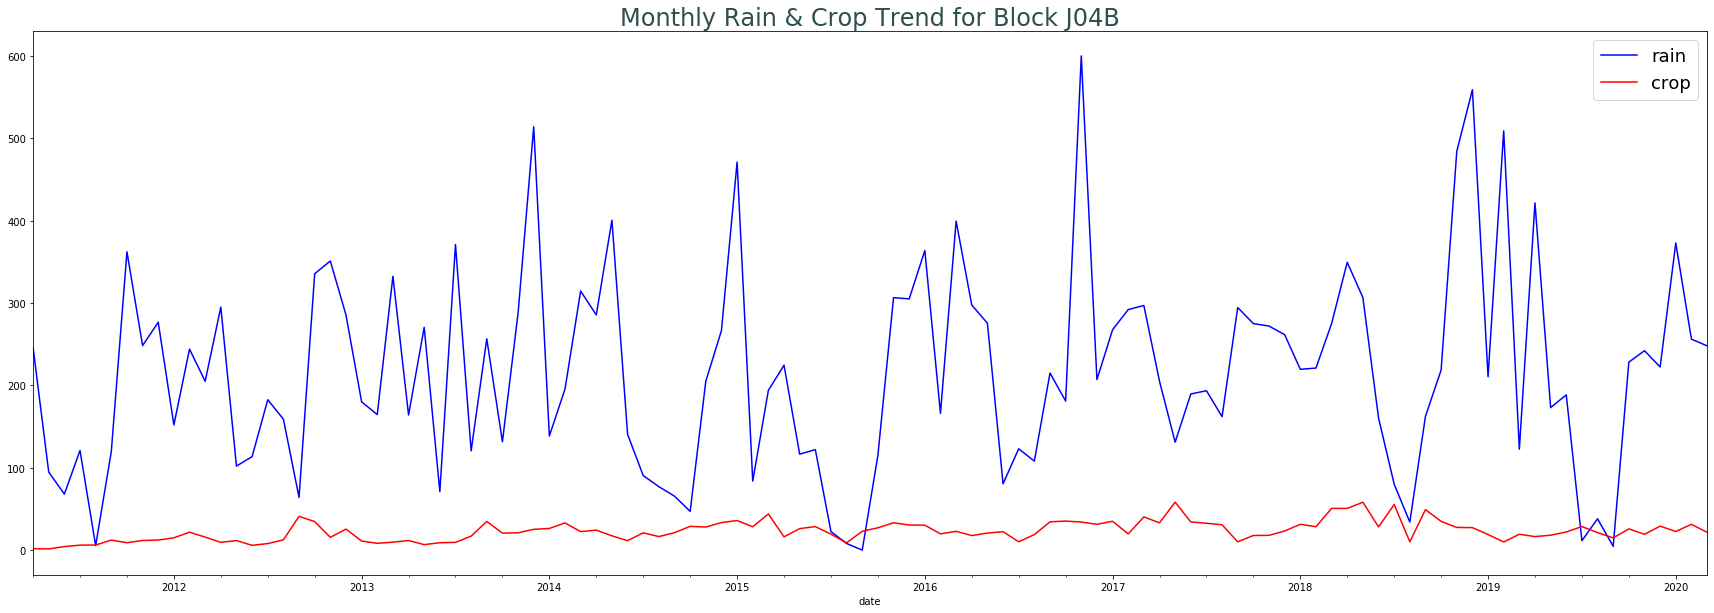

In [79]:
# for Blocks J04b : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in j04b_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
#xlabel='Months'
#ylabel='Crop'
title = 'Monthly Rain & Crop Trend for Block J04B'
fig, ax = plt.subplots(figsize=(30,10))
j04b_m['rain'].plot(kind='line',color='blue');
j04b_m['crop'].plot(kind='line',color='red');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.legend(fontsize=18);
plt.show();

**Block J06 which is top block for crop yield in 2018**

In [80]:
j06 = dfi.copy()
j06 = j06[j06['blk'] == 'J06']
j06_m = j04b[['rain','crop']].resample('M').sum()
j06_m['date'] = j06_m.index.date
j06_m['date'] = j06_m['date'].apply(lambda x: str(x))
j06_m['date'] = pd.to_datetime(j06_m['date'],yearfirst=True,format="%Y/%m") 
j06_m['month'] = j06_m['date'].apply(lambda x: x.strftime("%b-%Y"))# converting to name of the months and year
j06_m.head()

,rain,crop,date,month
date,,,,
2011-04-30,245.90,1.73195,2011-04-30,Apr-2011
2011-05-31,94.75,1.45333,2011-05-31,May-2011
2011-06-30,68.00,4.23174,2011-06-30,Jun-2011
2011-07-31,121.00,6.00886,2011-07-31,Jul-2011
2011-08-31,5.40,6.14907,2011-08-31,Aug-2011


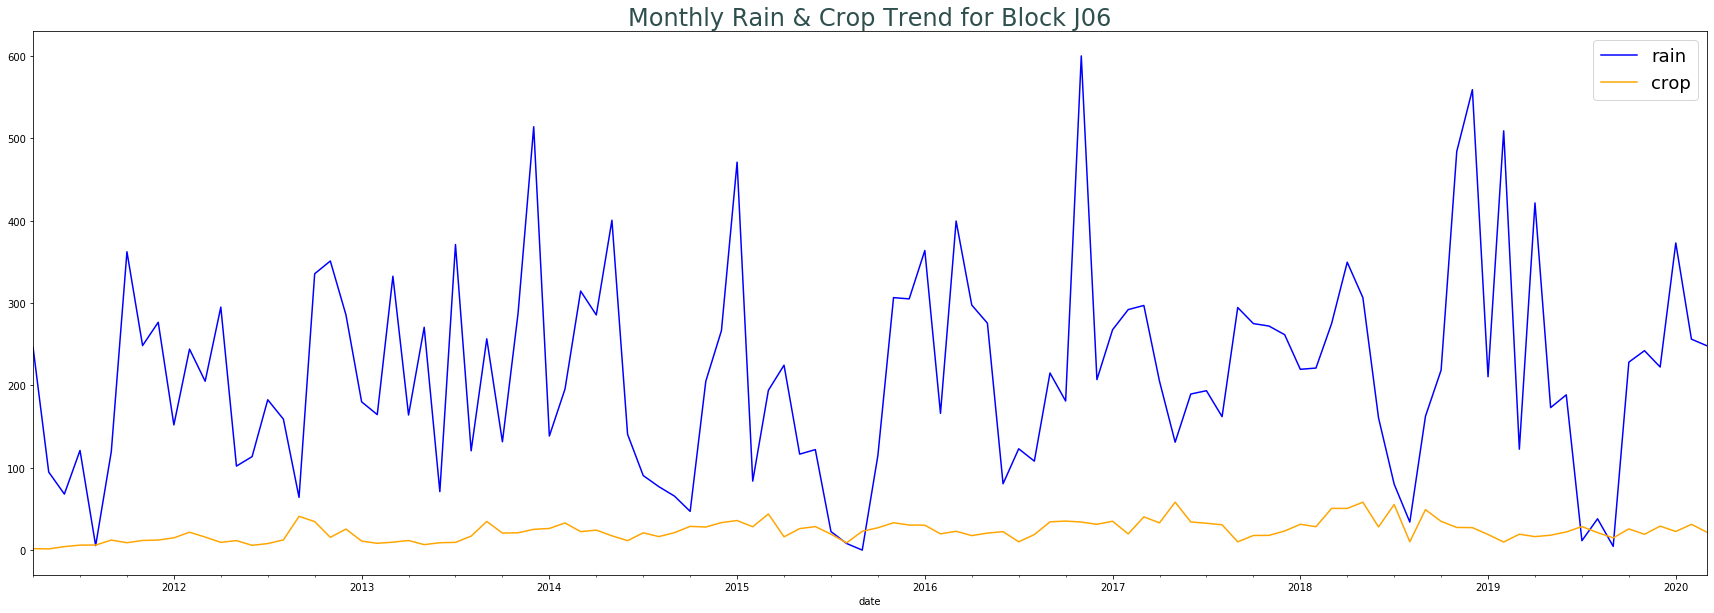

In [81]:
# for Blocks J06 : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in j04b_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
#xlabel='Months'
#ylabel='Crop'
title = 'Monthly Rain & Crop Trend for Block J06'
fig, ax = plt.subplots(figsize=(30,10))
j06_m['rain'].plot(kind='line',color='blue');
j06_m['crop'].plot(kind='line',color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.legend(fontsize=18);
plt.show();

**Block B06 which is top block for crop yield since 2011**

In [82]:
b06 = dfi.copy()
b06 = b06[b06['blk'] == 'B06']
b06_m = b06[['rain','crop']].resample('M').sum()
b06_m['date'] = b06_m.index.date
b06_m['date'] = b06_m['date'].apply(lambda x: str(x))
b06_m['date'] = pd.to_datetime(b06_m['date'],yearfirst=True,format="%Y/%m") 
b06_m['month'] = b06_m['date'].apply(lambda x: x.strftime("%b-%Y"))# converting to name of the months and year
b06_m.head()

,rain,crop,date,month
date,,,,
2011-04-30,245.90,65.10234,2011-04-30,Apr-2011
2011-05-31,94.75,76.16152,2011-05-31,May-2011
2011-06-30,68.00,66.17402,2011-06-30,Jun-2011
2011-07-31,121.00,101.72141,2011-07-31,Jul-2011
2011-08-31,5.40,70.07062,2011-08-31,Aug-2011


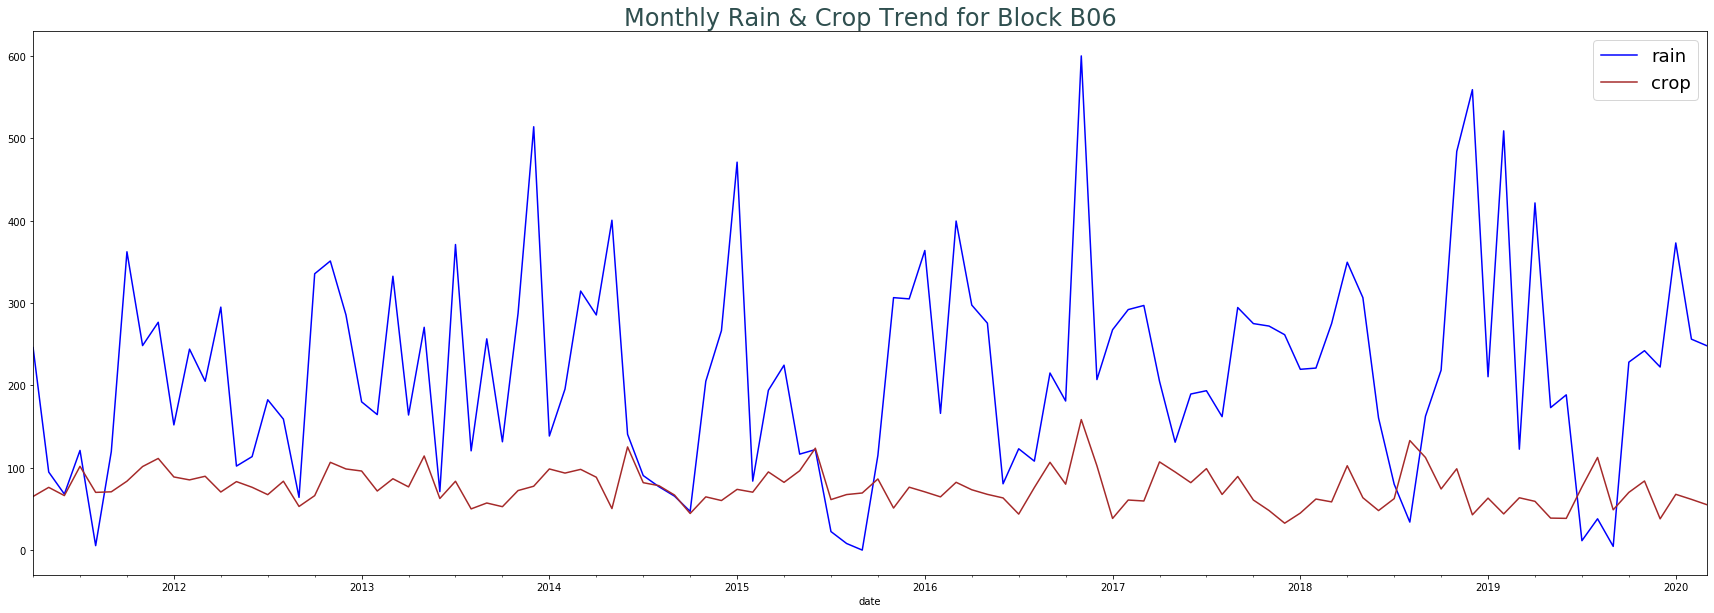

In [83]:
# for Blocks B06 : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in j04b_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
#xlabel='Months'
#ylabel='Crop'
title = 'Monthly Rain & Crop Trend for Block B06'
fig, ax = plt.subplots(figsize=(30,10))
b06_m['rain'].plot(kind='line',color='blue');
b06_m['crop'].plot(kind='line',color='brown');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
#ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.legend(fontsize=18);
plt.show();

#### Plot - Compare three top performing Blocks

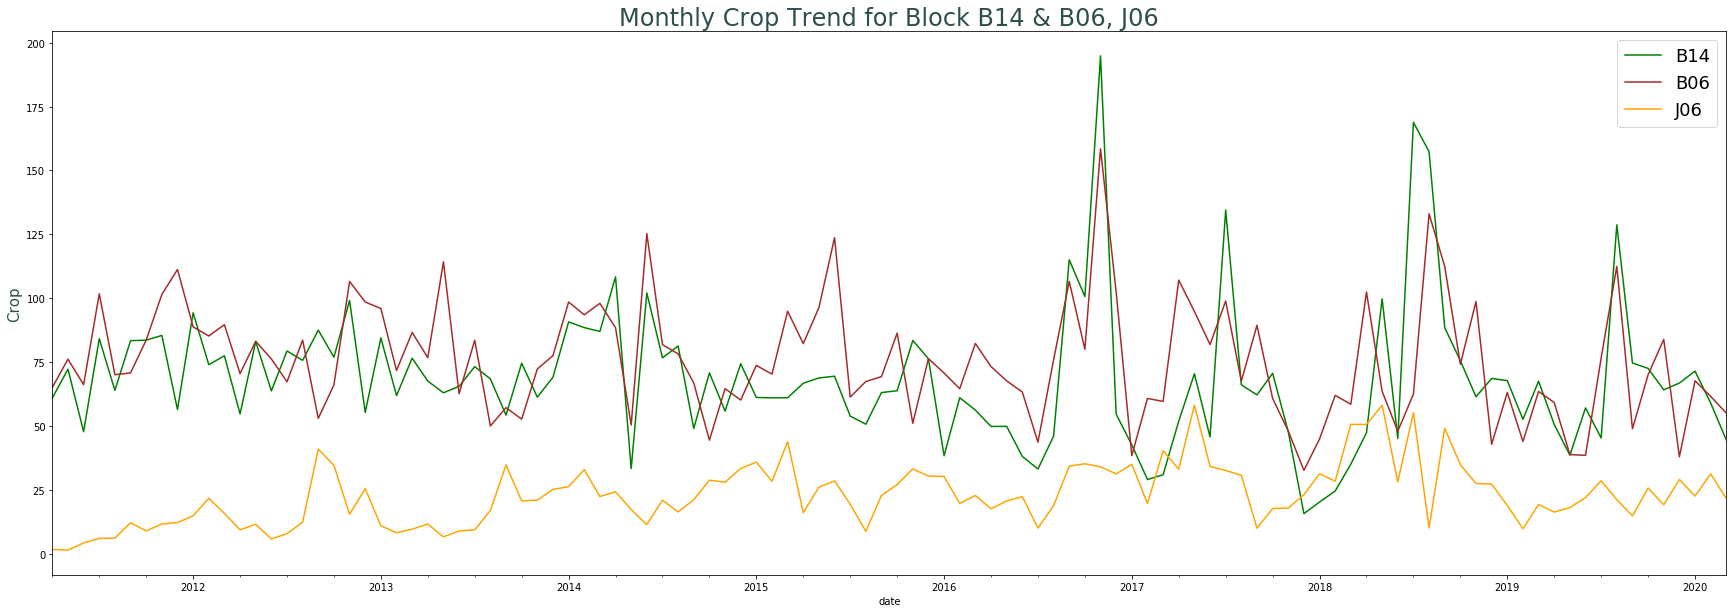

In [84]:
# for Blocks B14, B06 & J06 : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
#m_list = [m for m in j04b_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
#xlabel='Months'
ylabel='Crop'
title = 'Monthly Crop Trend for Block B14 & B06, J06'
fig, ax = plt.subplots(figsize=(30,10))
b14_m['crop'].plot(kind='line',color='green');
b06_m['crop'].plot(kind='line',color='brown');
j06_m['crop'].plot(kind='line',color='orange');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
#ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
#ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.legend(['B14','B06','J06'],fontsize=18);
plt.show();

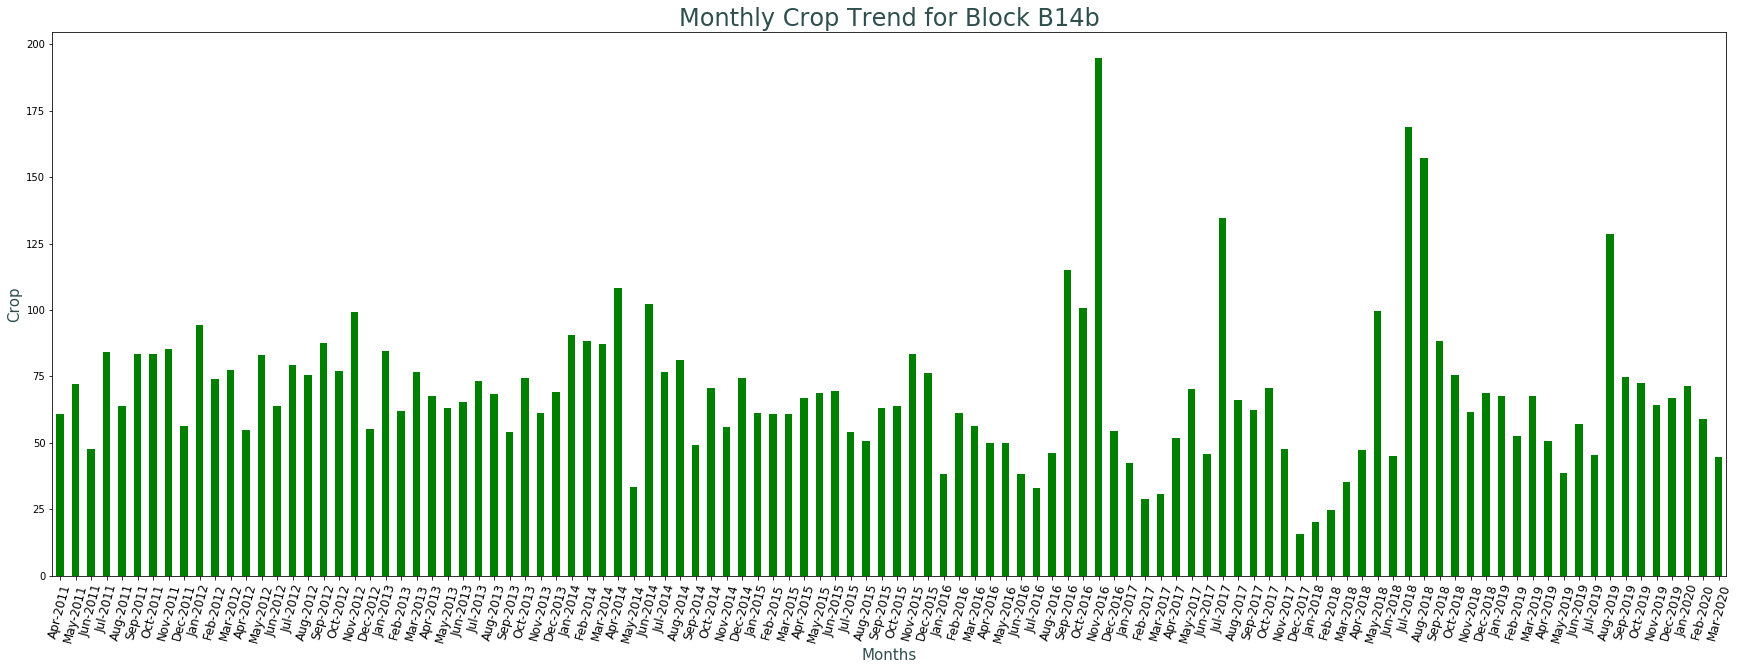

In [85]:
# for Blocks B14 : monthly crop trend using resampled df_m dataframe
#graph = df_m.copy()
m_list = [m for m in b14_m['month']] # for xticklabels
#xf=graph.index.year
#yf=graph['rain']
#cf=graph['']
xlabel='Months'
ylabel='Crop'
title = 'Monthly Crop Trend for Block B14b'
fig, ax = plt.subplots(figsize=(30,10))
b14_m['crop'].plot(kind='bar',color='green');
ax.set_title(title,color=my_title_col, fontsize = my_title_font);
ax.set_xlabel(xlabel,color=my_label_col, fontsize = 15);
ax.set_ylabel(ylabel,color=my_label_col, fontsize = 15);
ax.set_xticklabels(m_list,fontsize=12,rotation=75);
plt.show()

### Clustering using DBSCAN on fused dataset for year 2018 & 2019.
**Density Based Spatial Clustering of Application with Noise**

In [86]:
df.columns

Index(['blk', 'plant_mat', 'area_ha', 'no_of_palms', 'mth_of_plant', 'syp1_ha', 'syp1_prop', 'syp2_ha', 'syp2_prop', 'syp3_ha', 'syp3_prop', 'syp4_ha', 'syp4_prop', 'syp5_ha', 'syp5_prop', 'age', 'density', 'date', 'rain', 'crop'], dtype='object')

#### Creating dummy columns for palm species.

In [87]:
print(df.shape)
df_clus = df.copy()
df_clus = df_clus[df_clus['date'].dt.year == 2019 & 2018]
df_clus.drop(['date','blk','crop','mth_of_plant','area_ha'], axis=1, inplace=True) # droping blk and crop features
df_clus = pd.get_dummies(df_clus, columns=['plant_mat'],drop_first=True)
print(df_clus.shape)

(662596, 20)
(70445, 18)


In [88]:
df_clus.dtypes

no_of_palms                            int64
syp1_ha                              float64
syp1_prop                            float64
syp2_ha                              float64
syp2_prop                            float64
syp3_ha                              float64
syp3_prop                            float64
syp4_ha                              float64
syp4_prop                            float64
syp5_ha                              float64
syp5_prop                            float64
age                                    int64
density                                int64
rain                                 float64
plant_mat_LONSUM                       uint8
plant_mat_MIXED (DAMI/LONSUM)          uint8
plant_mat_MIXED (LONSUM/SOCFINDO)      uint8
plant_mat_SOCFINDO                     uint8
dtype: object

In [89]:
#scaling the dataset for clustering 
ss = StandardScaler()
clus_scaled = ss.fit_transform(df_clus)

In [90]:
# DBSCAN 
#dbs = DBSCAN()
#dbs.fit(clus_scaled)

In [91]:
#dbs.labels_


NameError: name 'dbs' is not defined

In [ ]:
set(dbs.labels_)

In [ ]:
silhouette_score(clus_scaled,dbs.labels_)

#### DBSCAN on Blocks Dataset

In [ ]:
blocks.columns

In [ ]:
print(blocks.shape)
df_clus = blocks.copy()
df_clus.drop(['blk','mth_of_plant'], axis=1, inplace=True) # droping blk and crop features
df_clus = pd.get_dummies(df_clus, columns=['plant_mat'],drop_first=True)
print(df_clus.shape)

In [ ]:
df_clus.dtypes


In [ ]:
#scaling the dataset for clustering 
ss = StandardScaler()
clus_scaled = ss.fit_transform(df_clus)

In [ ]:
# DBSCAN 
dbs = DBSCAN()
dbs.fit(clus_scaled)

In [ ]:
dbs.labels_

In [ ]:
set(dbs.labels_)

In [ ]:
silhouette_score(clus_scaled,dbs.labels_)

In [ ]:
# Create cluster column
df_clus['cluster'] = dbs.labels_

In [ ]:
df_clus['cluster'].value_counts()

In [ ]:
df_clus.columns

In [ ]:
# Pairplot
#graph = df_clus[['area_ha', 'no_of_palms', 'syp1_ha', 'syp1_prop', 'syp2_ha', 'syp2_prop', 'syp3_ha', 'syp3_prop', 'syp4_ha', 'syp4_prop', 'syp5_ha', 'syp5_prop', 'age','cluster']]
sns.pairplot(df_clus);
#sns.pairplot(graph,hue='cluster')

In [ ]:
for i in mydates:
    if i is in rain or i is in crop:
        if i is rain:
            rn = rn[rn['date'] == df.loc[i]['date']].index.values)
            rain_crop.append({'date':i,})

### Correlation Analysis

In [98]:
mod_df = df.copy()

#### Creating dummy feature for plant_mat(species)

In [109]:
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662596 entries, 0 to 662595
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   blk                                662596 non-null  object        
 1   area_ha                            662596 non-null  float64       
 2   no_of_palms                        662596 non-null  int64         
 3   mth_of_plant                       662596 non-null  datetime64[ns]
 4   syp1_ha                            662596 non-null  float64       
 5   syp1_prop                          662596 non-null  float64       
 6   syp2_ha                            662596 non-null  float64       
 7   syp2_prop                          662596 non-null  float64       
 8   syp3_ha                            662596 non-null  float64       
 9   syp3_prop                          662596 non-null  float64       
 10  syp4_ha             

In [99]:
mod_df = pd.get_dummies(mod_df, columns=['plant_mat'],drop_first=True)

In [100]:
mod_df.head()

,blk,area_ha,no_of_palms,mth_of_plant,syp1_ha,syp1_prop,syp2_ha,syp2_prop,syp3_ha,syp3_prop,syp4_ha,syp4_prop,syp5_ha,syp5_prop,age,density,date,rain,crop,plant_mat_LONSUM,plant_mat_MIXED (DAMI/LONSUM),plant_mat_MIXED (LONSUM/SOCFINDO),plant_mat_SOCFINDO
0,A07,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,2011-04-01,24.0,0.0,0,0,0,0
1,A07,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,2011-04-02,8.9,0.0,0,0,0,0
2,A07,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,2011-04-03,0.0,0.0,0,0,0,0
3,A07,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,2011-04-04,3.8,0.0,0,0,0,0
4,A07,13.1,1825,1999-12-01,4.3,0.328244,4.5,0.343511,0.0,0.0,4.3,0.328244,0.0,0.0,250,139,2011-04-05,7.0,0.0,0,0,0,0


#### Select numeric columns

In [101]:
# Exctrating continous columns into separate dataframe
nums_df = mod_df.select_dtypes(exclude=['object'])

In [102]:
# function to explore the descriptive values and correlatio with target variable SalePrice
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    #print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    return str

In [103]:
# review the correlation with SalePrice as well as nulls and missing values of each feature 
details = rstr(nums_df,'crop')
display(details.sort_values(by='crop', ascending=False))

,0,1,2,3,4,5,6,7,crop
crop,float64,662596,95180,0,0.000000,"[[0.0, 10.21161, 1.83916, 4.70633, 8.55521, 8....",4.903673,36.727254,1.000000
area_ha,float64,662596,147,0,0.000000,"[[13.1, 21.7, 21.6, 22.3, 22.2, 21.5, 21.4, 11...",-0.256929,-0.773591,0.116285
no_of_palms,int64,662596,190,0,0.000000,"[[1825, 2911, 2927, 2940, 2878, 2900, 2723, 27...",-0.326162,-0.671081,0.115662
age,int64,662596,38,0,0.000000,"[[250, 259, 263, 262, 251, 243, 260, 261, 247,...",-0.329980,-1.128312,0.070668
syp1_ha,float64,662596,127,0,0.000000,"[[4.3, 10.4, 21.6, 22.3, 22.2, 21.5, 21.4, 9.6...",0.531653,-0.860183,0.068237
syp2_ha,float64,662596,88,0,0.000000,"[[4.5, 7.7, 0.0, 0.9, 1.9, 22.3, 15.7, 6.1, 15...",1.511218,1.564276,0.026269
syp3_ha,float64,662596,26,0,0.000000,"[[0.0, 2.1, 1.3, 1.9, 5.0, 4.7, 7.3, 3.3, 9.8,...",4.226800,18.088927,0.021734
syp3_prop,float64,662596,28,0,0.000000,"[[0.0, 0.0646153846153846, 0.0415335463258786,...",4.209863,18.352943,0.017181
syp5_ha,float64,662596,8,0,0.000000,"[[0.0, 1.4, 4.9, 1.2, 9.9, 6.0, 7.3, 1.8]]",7.153466,53.518037,0.016448
syp5_prop,float64,662596,8,0,0.000000,"[[0.0, 0.0528301886792453, 0.182835820895522, ...",7.244386,56.312650,0.015550


In [104]:
# stores cross columns correlation matrix of continous features in final_corr dataframe
final_corr = nums_df.corr()

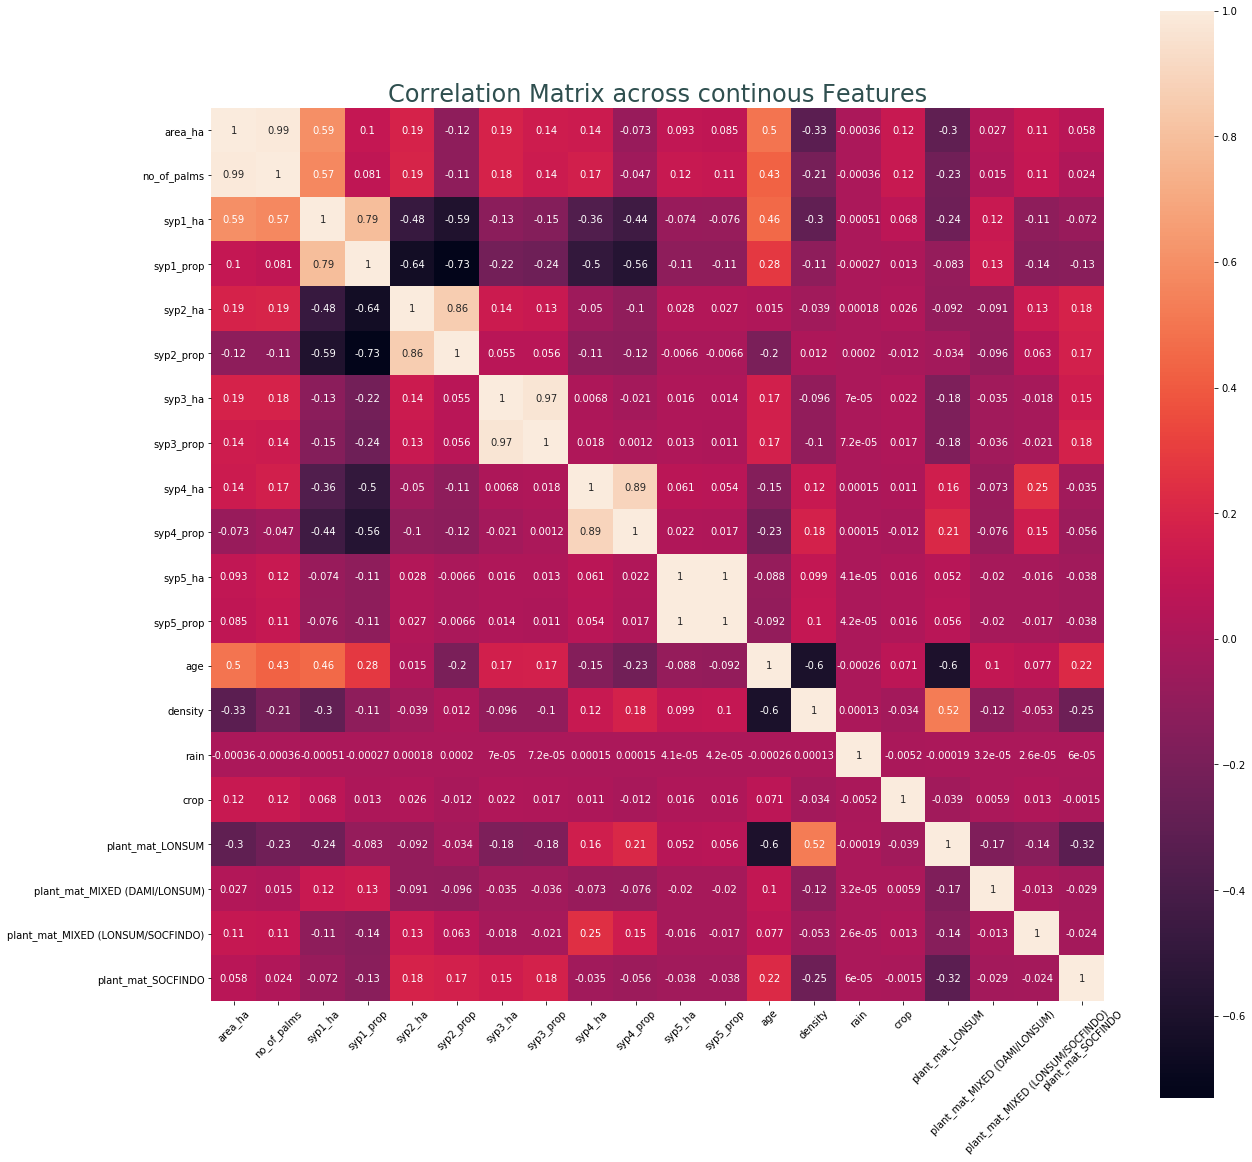

In [105]:
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(20,20));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix across continous Features",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

#### Correlation on monthly Rain and Crop Data at Estate level 

In [106]:
# Exctrating continous columns into separate dataframe
nums_df = df_m.select_dtypes(exclude=['object'])

In [107]:
final_corr = nums_df.corr()

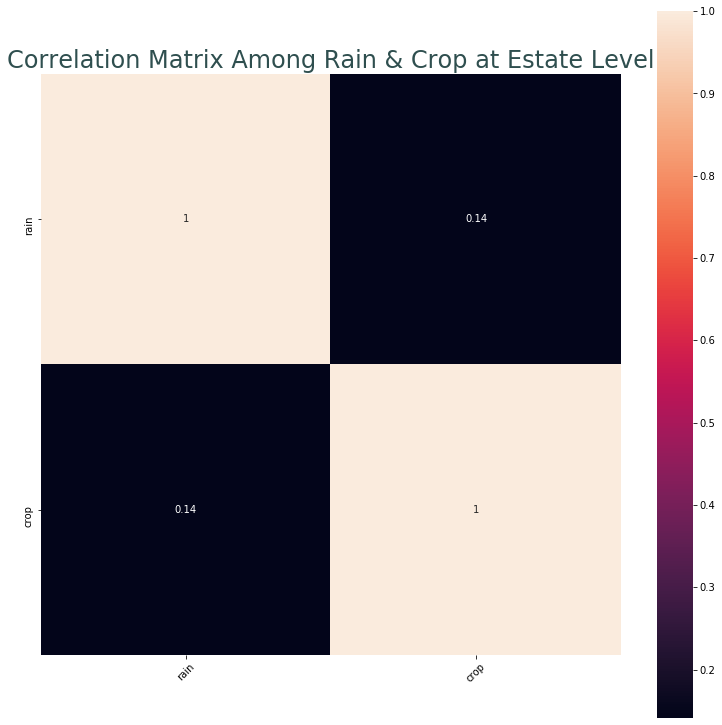

In [108]:
# create Seaborn heat map for cross columns correlation matrix stored within final_corr object.
fig, ax = plt.subplots(figsize=(13,13));
ax = sns.heatmap(final_corr, annot=True,square=True);
ax.set_title("Correlation Matrix Among Rain & Crop at Estate Level",color=my_title_col, fontsize = my_title_font);
plt.xticks(rotation=45);

## Modeling 

### Approach
- Monthly consolidated rain and crop data for entire estate will be used.
- Data from 1-Apr-2011 to 31-Dec-2019 will be used to train and validate
- Data from 1-Jan-2020 to 31-May-2020

Refer to palm3_modeling notebook for detailed modeling code.

## Scratch Pad

# way to format date xtick labels 
# Import necessary packages
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import pandas as pd
import earthpy as et

fig, ax = plt.subplots(figsize=(12, 12))

# Add x-axis and y-axis
ax.bar(precip_june_aug_2005.index.values,
       precip_june_aug_2005['DAILY_PRECIP'],
       color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek")

# Define the date format
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

#rolling yearly, monthly, daily average for Station 1 


yearly_st1 = w_df_st1['tmax'].resample('A').mean()

monthly_st1 = w_df_st1['tmax'].resample('M').mean()

roll_3_years_st1 = w_df_st1['tmax'].resample('A').mean().rolling(window=3, center=False).mean()

roll_3_mnths_st1 = w_df_st1['tmax'].resample('M').mean().rolling(window=3, center=False).mean()

roll_6_mnths_st1 = w_df_st1['tmax'].resample('M').mean().rolling(window=6, center=False).mean()

daily_st1 = w_df_st1['tmax']

roll_60days_st1 = w_df_st1['tmax'].rolling(window=60, center=False).mean()


#rolling yearly, monthly, daily average for Station 2

yearly_st2 = w_df_st2['tmax'].resample('A').mean()

monthly_st2 = w_df_st2['tmax'].resample('M').mean()

roll_3_years_st2 = w_df_st2['tmax'].resample('A').mean().rolling(window=3, center=False).mean()

roll_3_mnths_st2 = w_df_st2['tmax'].resample('M').mean().rolling(window=3, center=False).mean()

roll_6_mnths_st2 = w_df_st2['tmax'].resample('M').mean().rolling(window=6, center=False).mean()

daily_st2 = w_df_st2['tmax']

roll_60days_st2 = w_df_st2['tmax'].rolling(window=60, center=False).mean()

